In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.models.gaussian_process import *


from encoding_information.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2023-11-13 02:28:14.132082: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Opening BSCCM
Opened BSCCM


### Generate a ground truth stationary matrix by estimating from samples

In [2]:
# Generate a ground truth covariance matrix for each channel, and then noiseless samples from it
from encoding_information.models.gaussian_process import StationaryGaussianProcess

num_images = 10000
num_patches = 10000
# num_images = 1000
# num_patches = 1000
edge_crop = 24

patch_size = 20

channel = 'LED119'


images = load_bsccm_images(bsccm, channel=channel, num_images=num_images, edge_crop=edge_crop, median_filter=False)
patches = extract_patches(images, patch_size, num_patches=num_patches)

cov_mat = estimate_full_cov_mat(patches)
gp = StationaryGaussianProcess(patches)
gp.fit(patches)
true_cov_mat_px = gp.get_cov_mat()
true_mean_px = np.mean(images)

samples = gp.generate_samples(num_samples=num_patches, sample_shape=patch_size, ensure_nonnegative=True)

2023-11-13 02:30:02.703130: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


Initial validation NLL: 4376.50


Epoch 1: 100%|███████████████████████████| 1/1 [00:05<00:00,  5.88s/it]


Epoch 1: validation NLL: 4.49


Epoch 2: 100%|███████████████████████████| 1/1 [00:00<00:00, 32.49it/s]


Epoch 2: validation NLL: 4.46


Epoch 3: 100%|███████████████████████████| 1/1 [00:00<00:00, 33.47it/s]


Epoch 3: validation NLL: 4.45


Epoch 4: 100%|███████████████████████████| 1/1 [00:00<00:00, 37.72it/s]


Epoch 4: validation NLL: 4.45


Epoch 5: 100%|███████████████████████████| 1/1 [00:00<00:00, 37.83it/s]


Epoch 5: validation NLL: 4.45


Epoch 6: 100%|███████████████████████████| 1/1 [00:00<00:00, 39.16it/s]


Epoch 6: validation NLL: 4.45


Epoch 7: 100%|███████████████████████████| 1/1 [00:00<00:00, 42.06it/s]


Epoch 7: validation NLL: 4.45


Epoch 8: 100%|███████████████████████████| 1/1 [00:00<00:00, 44.71it/s]


Epoch 8: validation NLL: 4.46


Epoch 9: 100%|███████████████████████████| 1/1 [00:00<00:00, 31.80it/s]


Epoch 9: validation NLL: 4.46


Epoch 10: 100%|██████████████████████████| 1/1 [00:00<00:00, 44.14it/s]


Epoch 10: validation NLL: 4.46


Epoch 11: 100%|██████████████████████████| 1/1 [00:00<00:00, 43.92it/s]


Epoch 11: validation NLL: 4.46


Epoch 12: 100%|██████████████████████████| 1/1 [00:00<00:00, 43.44it/s]


Epoch 12: validation NLL: 4.46


Epoch 13: 100%|██████████████████████████| 1/1 [00:00<00:00, 42.63it/s]


Epoch 13: validation NLL: 4.46


Epoch 14: 100%|██████████████████████████| 1/1 [00:00<00:00, 43.81it/s]


Epoch 14: validation NLL: 4.46


Epoch 15: 100%|██████████████████████████| 1/1 [00:00<00:00, 43.52it/s]


Epoch 15: validation NLL: 4.46


Epoch 16: 100%|██████████████████████████| 1/1 [00:00<00:00, 43.57it/s]


Epoch 16: validation NLL: 4.46


Epoch 17: 100%|██████████████████████████| 1/1 [00:00<00:00, 44.48it/s]


Epoch 17: validation NLL: 4.46


Epoch 18: 100%|██████████████████████████| 1/1 [00:00<00:00, 44.36it/s]


Epoch 18: validation NLL: 4.46


Epoch 19: 100%|██████████████████████████| 1/1 [00:00<00:00, 44.20it/s]


Epoch 19: validation NLL: 4.46


Epoch 20: 100%|██████████████████████████| 1/1 [00:00<00:00, 44.74it/s]


Epoch 20: validation NLL: 4.46


### Verify that mutual information estimates are consistent: they converge to the correct value given enough samples (for stationary gaussian, optimized stationary gaussian, pixelCNN)
Of course, this is on data that is sampled form a stationary gaussian process, so its only really showing that the gaussian approximation estimator can estimate gaussian entropy and MI. 


This all uses additive gaussian noise, which has an easy analytic formula for h(y | x)


In [3]:
num_samples_to_use = np.array([10, 20, 40, 80, 160, 320, 640, 1280, 2560]).astype(int)
# num_bootstrap_samples = 10
num_bootstrap_samples = 80

gaussian_sigma = 50
confidence_interval = 90

true_cov_mat_py = true_cov_mat_px + gaussian_sigma**2 * np.eye(patch_size**2)
h_y_analytic = analytic_multivariate_gaussian_entropy(true_cov_mat_py) 
# Constant conditional entropy for Gaussian noise
h_y_given_x_analytic = analytic_multivariate_gaussian_entropy(np.eye(patch_size**2) * gaussian_sigma**2) 
mi_analytic_per_pixel = (h_y_analytic - h_y_given_x_analytic) / np.log(2)

noisy_samples = add_noise(samples, gaussian_sigma=gaussian_sigma, ensure_positive=True)


stationary_mi_estimates_gp_mean = []
stationary_mi_estimates_gp_conf_int = []
stationary_mi_estimates_gp_optimized_mean = []
stationary_mi_estimates_gp_optimized_conf_int = []
stationary_mi_estimates_pixelcnn_optimized_mean = []
stationary_mi_estimates_pixelcnn_optimized_conf_int = []

ev_floor = 1e-1
for num_to_use in tqdm(num_samples_to_use):


    if not os.path.exists('.cache'):
        os.mkdir('.cache')
    if os.path.exists('.cache/mi_estimates_{}_cache_{}_samples.npz'.format(channel, num_to_use)):
        print('loading cached version of MI estimates')
        loaded = onp.load('.cache/mi_estimates_{}_cache_{}_samples.npz'.format(channel, num_to_use))
        # append to the list of estimates
        stationary_mi_estimates_gp_mean.append(loaded['stationary_mi_estimates_gp_mean'])
        stationary_mi_estimates_gp_conf_int.append(loaded['stationary_mi_estimates_gp_conf_int'])
        stationary_mi_estimates_gp_optimized_mean.append(loaded['stationary_mi_estimates_gp_optimized_mean'])
        stationary_mi_estimates_gp_optimized_conf_int.append(loaded['stationary_mi_estimates_gp_optimized_conf_int'])
        stationary_mi_estimates_pixelcnn_optimized_mean.append(loaded['stationary_mi_estimates_pixelcnn_optimized_mean'])
        stationary_mi_estimates_pixelcnn_optimized_conf_int.append(loaded['stationary_mi_estimates_pixelcnn_optimized_conf_int'])
    else:

        # estimate MI using stationary estimator
        num_val_samples = max(1, min(1000, 0.1 * num_to_use))
        

        # stationary estimator with GP no optimization
        mean, conf_int = run_bootstrap(noisy_samples[:num_to_use],
                        num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval, estimation_fn=
                        lambda noisy_images: estimate_mutual_information(noisy_images, num_val_samples=num_val_samples,
                        eigenvalue_floor=ev_floor, gaussian_noise_sigma = gaussian_sigma, use_iterative_optimization=False ) ,
                        upper_bound_confidence_interval=True,
                        )
        stationary_mi_estimates_gp_mean.append(mean)
        stationary_mi_estimates_gp_conf_int.append(conf_int)

        # stationary estimator with GP optimization
        mean, conf_int = run_bootstrap(noisy_samples[:num_to_use], 
                        num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval, estimation_fn=
                        lambda noisy_images: estimate_mutual_information(noisy_images, num_val_samples=num_val_samples,
                        eigenvalue_floor=ev_floor, gaussian_noise_sigma = gaussian_sigma, patience=50, max_epochs=100, use_iterative_optimization=True),
                         upper_bound_confidence_interval=True,
                          )
        stationary_mi_estimates_gp_optimized_mean.append(mean)
        stationary_mi_estimates_gp_optimized_conf_int.append(conf_int)

        # pixelcnn
        mean, conf_int = run_bootstrap(noisy_samples[:num_to_use],
                        num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval, estimation_fn=
                        lambda noisy_images: estimate_mutual_information(noisy_images, num_val_samples=num_val_samples,
                        eigenvalue_floor=ev_floor, gaussian_noise_sigma = gaussian_sigma, 
                        entropy_model='pixel_cnn'),
                        upper_bound_confidence_interval=True,
                        )
        stationary_mi_estimates_pixelcnn_optimized_mean.append(mean)
        stationary_mi_estimates_pixelcnn_optimized_conf_int.append(conf_int)


            # save all these results to a numpy file
        onp.savez('.cache/mi_estimates_{}_cache_{}_samples'.format(channel, num_to_use),
                stationary_mi_estimates_gp_mean=onp.array(stationary_mi_estimates_gp_mean[-1]),
                stationary_mi_estimates_gp_conf_int=onp.array(stationary_mi_estimates_gp_conf_int[-1]),
                stationary_mi_estimates_gp_optimized_mean=onp.array(stationary_mi_estimates_gp_optimized_mean[-1]),
                stationary_mi_estimates_gp_optimized_conf_int=onp.array(stationary_mi_estimates_gp_optimized_conf_int[-1]),
                stationary_mi_estimates_pixelcnn_optimized_mean=onp.array(stationary_mi_estimates_pixelcnn_optimized_mean[-1]),
                stationary_mi_estimates_pixelcnn_optimized_conf_int=onp.array(stationary_mi_estimates_pixelcnn_optimized_conf_int[-1]),
                )
                


stationary_mi_estimates_gp_mean = np.array(stationary_mi_estimates_gp_mean)
stationary_mi_estimates_gp_conf_int = np.array(stationary_mi_estimates_gp_conf_int)
stationary_mi_estimates_gp_optimized_mean = np.array(stationary_mi_estimates_gp_optimized_mean)
stationary_mi_estimates_gp_optimized_conf_int = np.array(stationary_mi_estimates_gp_optimized_conf_int)
stationary_mi_estimates_pixelcnn_optimized_mean = np.array(stationary_mi_estimates_pixelcnn_optimized_mean)
stationary_mi_estimates_pixelcnn_optimized_conf_int = np.array(stationary_mi_estimates_pixelcnn_optimized_conf_int)

100%|████████████████████████████████████| 9/9 [00:00<00:00, 87.88it/s]

loading cached version of MI estimates
loading cached version of MI estimates
loading cached version of MI estimates
loading cached version of MI estimates
loading cached version of MI estimates
loading cached version of MI estimates
loading cached version of MI estimates
loading cached version of MI estimates
loading cached version of MI estimates


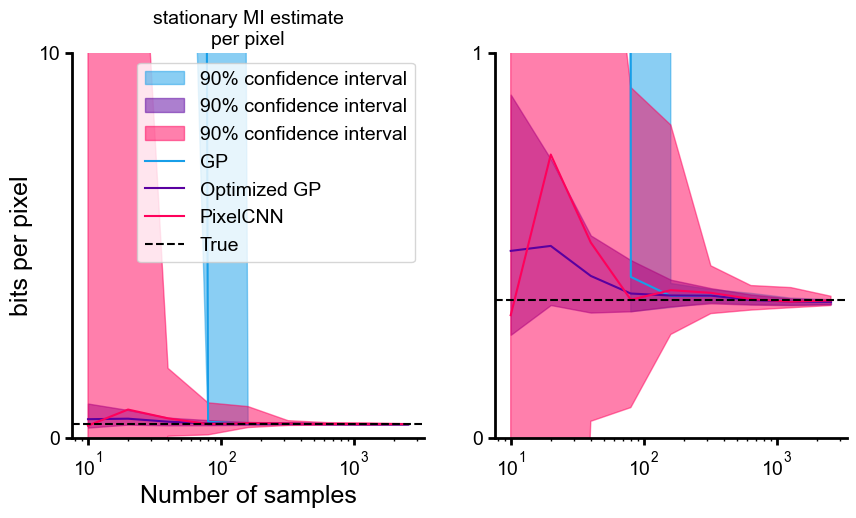

In [4]:
colors = get_color_cycle()
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
ax[0].fill_between(num_samples_to_use, stationary_mi_estimates_gp_conf_int[:,0], 
                stationary_mi_estimates_gp_conf_int[:,1], alpha=0.5, label=f'{confidence_interval}% confidence interval', color=colors[0])
ax[0].fill_between(num_samples_to_use, stationary_mi_estimates_gp_optimized_conf_int[:,0],
                stationary_mi_estimates_gp_optimized_conf_int[:,1], alpha=0.5, label=f'{confidence_interval}% confidence interval', color=colors[1])
ax[0].fill_between(num_samples_to_use, stationary_mi_estimates_pixelcnn_optimized_conf_int[:,0],
                stationary_mi_estimates_pixelcnn_optimized_conf_int[:,1], alpha=0.5, label=f'{confidence_interval}% confidence interval', color=colors[2])
ax[0].semilogx(num_samples_to_use, stationary_mi_estimates_gp_mean, label='GP', color=colors[0])
ax[0].semilogx(num_samples_to_use, stationary_mi_estimates_gp_optimized_mean, label='Optimized GP', color=colors[1])
ax[0].semilogx(num_samples_to_use, stationary_mi_estimates_pixelcnn_optimized_mean, label='PixelCNN', color=colors[2])

ax[0].axhline(mi_analytic_per_pixel, color='k', linestyle='--', label='True')

ax[0].set(ylim=[0, 10], yticks=[0, 10])

ax[0].set(xlabel='Number of samples', title='stationary MI estimate\nper pixel', ylabel='bits per pixel')
clear_spines(ax[0])
ax[0].legend()


ax[1].fill_between(num_samples_to_use, stationary_mi_estimates_gp_conf_int[:,0], 
                stationary_mi_estimates_gp_conf_int[:,1], alpha=0.5, label=f'{confidence_interval}% confidence interval', color=colors[0])
ax[1].fill_between(num_samples_to_use, stationary_mi_estimates_gp_optimized_conf_int[:,0],
                stationary_mi_estimates_gp_optimized_conf_int[:,1], alpha=0.5, label=f'{confidence_interval}% confidence interval', color=colors[1])
ax[1].fill_between(num_samples_to_use, stationary_mi_estimates_pixelcnn_optimized_conf_int[:,0],
                stationary_mi_estimates_pixelcnn_optimized_conf_int[:,1], alpha=0.5, label=f'{confidence_interval}% confidence interval', color=colors[2])
ax[1].semilogx(num_samples_to_use, stationary_mi_estimates_gp_mean, label='GP', color=colors[0])
ax[1].semilogx(num_samples_to_use, stationary_mi_estimates_gp_optimized_mean, label='Optimized GP', color=colors[1])
ax[1].semilogx(num_samples_to_use, stationary_mi_estimates_pixelcnn_optimized_mean, label='PixelCNN', color=colors[2])

ax[1].axhline(mi_analytic_per_pixel, color='k', linestyle='--', label='True')

ax[1].set(ylim=[0, 1], yticks=[0, 1])
clear_spines(ax[1])

fig.savefig('/home/hpinkard_waller/figures/mi_estimation/' + 'mi_estimator_consistency_gaussian_target' + '.pdf', transparent=True)

# Same MI consistency plot, but with samples from data distrbution instead of GP
Cant show it converging to true value, but can show that it converges to a (probably biased) estimate

In [5]:

stationary_mi_estimates_gp_mean = []
stationary_mi_estimates_gp_conf_int = []
stationary_mi_estimates_gp_optimized_mean = []
stationary_mi_estimates_gp_optimized_conf_int = []
stationary_mi_estimates_pixelcnn_optimized_mean = []
stationary_mi_estimates_pixelcnn_optimized_conf_int = []


# images = load_bsccm_images(bsccm, channel=channel, num_images=num_images, edge_crop=edge_crop, median_filter=True)
# patches = extract_patches(images, patch_size, num_patches=num_patches)
# patches = add_noise(patches)

ev_floor = 1e-3
for num_to_use in tqdm(num_samples_to_use):

    if not os.path.exists('.cache'):
        os.mkdir('.cache')
    if os.path.exists('.cache/mi_estimates_{}_no_gt_cache_{}_samples.npz'.format(channel, num_to_use)):
        print('loading cached version of MI estimates')
        loaded = onp.load('.cache/mi_estimates_{}_no_gt_cache_{}_samples.npz'.format(channel, num_to_use))
        # append to the list of estimates
        stationary_mi_estimates_gp_mean.append(loaded['stationary_mi_estimates_gp_mean'])
        stationary_mi_estimates_gp_conf_int.append(loaded['stationary_mi_estimates_gp_conf_int'])
        stationary_mi_estimates_gp_optimized_mean.append(loaded['stationary_mi_estimates_gp_optimized_mean'])
        stationary_mi_estimates_gp_optimized_conf_int.append(loaded['stationary_mi_estimates_gp_optimized_conf_int'])
        stationary_mi_estimates_pixelcnn_optimized_mean.append(loaded['stationary_mi_estimates_pixelcnn_optimized_mean'])
        stationary_mi_estimates_pixelcnn_optimized_conf_int.append(loaded['stationary_mi_estimates_pixelcnn_optimized_conf_int'])
    else:

        # estimate MI using stationary estimator
        num_val_samples = max(1, min(1000, 0.1 * num_to_use))

        mean, conf_int = run_bootstrap(patches[:num_to_use], 
                        num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval, estimation_fn=
                        lambda noisy_images: estimate_mutual_information(noisy_images, num_val_samples=num_val_samples,
                        eigenvalue_floor=ev_floor, use_iterative_optimization=False, verbose=True) ,
                        upper_bound_confidence_interval=True,
                        )
        stationary_mi_estimates_gp_mean.append(mean)
        stationary_mi_estimates_gp_conf_int.append(conf_int)

        mean, conf_int = run_bootstrap(patches[:num_to_use], 
                        num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval, estimation_fn=
                        lambda noisy_images: estimate_mutual_information(noisy_images, num_val_samples=num_val_samples,
                        eigenvalue_floor=ev_floor, patience=50, max_epochs=100, use_iterative_optimization=True) ,
                        upper_bound_confidence_interval=True,                        
                        )
        stationary_mi_estimates_gp_optimized_mean.append(mean)
        stationary_mi_estimates_gp_optimized_conf_int.append(conf_int)

        mean, conf_int = run_bootstrap(patches[:num_to_use],
                        num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval, estimation_fn=
                        lambda noisy_images: estimate_mutual_information(noisy_images, num_val_samples=num_val_samples,
                        eigenvalue_floor=ev_floor,  entropy_model='pixel_cnn') ,
                        upper_bound_confidence_interval=True,
                        )
        stationary_mi_estimates_pixelcnn_optimized_mean.append(mean)
        stationary_mi_estimates_pixelcnn_optimized_conf_int.append(conf_int)



            # save all these results to a numpy file
        onp.savez('.cache/mi_estimates_{}_no_gt_cache_{}_samples'.format(channel, num_to_use),
                stationary_mi_estimates_gp_mean=onp.array(stationary_mi_estimates_gp_mean[-1]),
                stationary_mi_estimates_gp_conf_int=onp.array(stationary_mi_estimates_gp_conf_int[-1]),
                stationary_mi_estimates_gp_optimized_mean=onp.array(stationary_mi_estimates_gp_optimized_mean[-1]),
                stationary_mi_estimates_gp_optimized_conf_int=onp.array(stationary_mi_estimates_gp_optimized_conf_int[-1]),
                stationary_mi_estimates_pixelcnn_optimized_mean=onp.array(stationary_mi_estimates_pixelcnn_optimized_mean[-1]),
                stationary_mi_estimates_pixelcnn_optimized_conf_int=onp.array(stationary_mi_estimates_pixelcnn_optimized_conf_int[-1]),
                )
                

stationary_mi_estimates_gp_mean = np.array(stationary_mi_estimates_gp_mean)
stationary_mi_estimates_gp_conf_int = np.array(stationary_mi_estimates_gp_conf_int)
stationary_mi_estimates_gp_optimized_mean = np.array(stationary_mi_estimates_gp_optimized_mean)
stationary_mi_estimates_gp_optimized_conf_int = np.array(stationary_mi_estimates_gp_optimized_conf_int)
stationary_mi_estimates_pixelcnn_optimized_mean = np.array(stationary_mi_estimates_pixelcnn_optimized_mean)
stationary_mi_estimates_pixelcnn_optimized_conf_int = np.array(stationary_mi_estimates_pixelcnn_optimized_conf_int)

  0%|                                            | 0/9 [00:00<?, ?it/s]

loading cached version of MI estimates
loading cached version of MI estimates
loading cached version of MI estimates
loading cached version of MI estimates



precomputing masks and variances:   7%| | 1/15 [00:00<00:01,  8.19it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 65.22it/s


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 124.15it/s]


Estimated H(Y|X) = 4.375 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4557.345 differential entropy/pixel
Estimated I(Y;X) = 6568.547 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 124.86it/

evaluating likelihood




computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 125.13it/s]


Estimated H(Y|X) = 4.368 differential entropy/pixel
Estimated H(Y) (Upper bound) = 18044.238 differential entropy/pixel
Estimated I(Y;X) = 26026.031 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 120.46it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 117.54it/s]


Estimated H(Y|X) = 4.384 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7924.890 differential entropy/pixel
Estimated I(Y;X) = 11426.875 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 119.78it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 117.30it/s]


Estimated H(Y|X) = 4.383 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6428.427 differential entropy/pixel
Estimated I(Y;X) = 9267.937 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 128.29it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 117.14it/s]


Estimated H(Y|X) = 4.379 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6221.918 differential entropy/pixel
Estimated I(Y;X) = 8970.012 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 129.86it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 127.69it/s]


Estimated H(Y|X) = 4.382 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6281.161 differential entropy/pixel
Estimated I(Y;X) = 9055.478 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 119.90it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 105.36it/s]


Estimated H(Y|X) = 4.382 differential entropy/pixel
Estimated H(Y) (Upper bound) = 15890.768 differential entropy/pixel
Estimated I(Y;X) = 22919.209 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 136.74it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 140.11it/s]


Estimated H(Y|X) = 4.375 differential entropy/pixel
Estimated H(Y) (Upper bound) = 10448.163 differential entropy/pixel
Estimated I(Y;X) = 15067.200 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 113.28it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 113.01it/s]


Estimated H(Y|X) = 4.368 differential entropy/pixel
Estimated H(Y) (Upper bound) = 10606.099 differential entropy/pixel
Estimated I(Y;X) = 15295.064 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 124.96it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 133.44it/s]


Estimated H(Y|X) = 4.393 differential entropy/pixel
Estimated H(Y) (Upper bound) = 14290.916 differential entropy/pixel
Estimated I(Y;X) = 20611.097 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 140.09it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 139.07it/s]


Estimated H(Y|X) = 4.379 differential entropy/pixel
Estimated H(Y) (Upper bound) = 13076.424 differential entropy/pixel
Estimated I(Y;X) = 18858.974 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 130.04it/

evaluating likelihood




computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 117.24it/s]


Estimated H(Y|X) = 4.390 differential entropy/pixel
Estimated H(Y) (Upper bound) = 9164.687 differential entropy/pixel
Estimated I(Y;X) = 13215.515 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 135.87it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 126.35it/s]


Estimated H(Y|X) = 4.358 differential entropy/pixel
Estimated H(Y) (Upper bound) = 15768.856 differential entropy/pixel
Estimated I(Y;X) = 22743.363 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 128.51it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 124.37it/s]


Estimated H(Y|X) = 4.369 differential entropy/pixel
Estimated H(Y) (Upper bound) = 12985.293 differential entropy/pixel
Estimated I(Y;X) = 18727.515 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 126.67it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 137.27it/s]


Estimated H(Y|X) = 4.382 differential entropy/pixel
Estimated H(Y) (Upper bound) = 9518.684 differential entropy/pixel
Estimated I(Y;X) = 13726.237 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 102.56it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 119.33it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 12220.412 differential entropy/pixel
Estimated I(Y;X) = 17624.001 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 110.67it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 110.30it/s]


Estimated H(Y|X) = 4.387 differential entropy/pixel
Estimated H(Y) (Upper bound) = 14265.175 differential entropy/pixel
Estimated I(Y;X) = 20573.968 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 131.51it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 112.64it/s]


Estimated H(Y|X) = 4.381 differential entropy/pixel
Estimated H(Y) (Upper bound) = 20669.266 differential entropy/pixel
Estimated I(Y;X) = 29813.126 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 144.32it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 144.33it/s]


Estimated H(Y|X) = 4.384 differential entropy/pixel
Estimated H(Y) (Upper bound) = 8034.080 differential entropy/pixel
Estimated I(Y;X) = 11584.403 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 132.68it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 146.11it/s]


Estimated H(Y|X) = 4.391 differential entropy/pixel
Estimated H(Y) (Upper bound) = 11075.298 differential entropy/pixel
Estimated I(Y;X) = 15971.943 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 119.58it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 125.72it/s]


Estimated H(Y|X) = 4.378 differential entropy/pixel
Estimated H(Y) (Upper bound) = 13049.003 differential entropy/pixel
Estimated I(Y;X) = 18819.416 bits/pixel



precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 154.15it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 140.33it/s]


Estimated H(Y|X) = 4.374 differential entropy/pixel
Estimated H(Y) (Upper bound) = 18653.156 differential entropy/pixel
Estimated I(Y;X) = 26904.505 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 132.92it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 160.48it/s]


Estimated H(Y|X) = 4.380 differential entropy/pixel
Estimated H(Y) (Upper bound) = 10823.185 differential entropy/pixel
Estimated I(Y;X) = 15608.237 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 139.78it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 135.43it/s]


Estimated H(Y|X) = 4.386 differential entropy/pixel
Estimated H(Y) (Upper bound) = 2908.904 differential entropy/pixel
Estimated I(Y;X) = 4190.334 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 137.04it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 133.86it/s]


Estimated H(Y|X) = 4.387 differential entropy/pixel
Estimated H(Y) (Upper bound) = 15674.368 differential entropy/pixel
Estimated I(Y;X) = 22607.004 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 111.90it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 105.50it/s]


Estimated H(Y|X) = 4.386 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6898.904 differential entropy/pixel
Estimated I(Y;X) = 9946.687 bits/pixel



precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 150.83it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 143.23it/s]


Estimated H(Y|X) = 4.377 differential entropy/pixel
Estimated H(Y) (Upper bound) = 12219.332 differential entropy/pixel
Estimated I(Y;X) = 17622.455 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 144.16it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 132.73it/s]


Estimated H(Y|X) = 4.377 differential entropy/pixel
Estimated H(Y) (Upper bound) = 15651.723 differential entropy/pixel
Estimated I(Y;X) = 22574.348 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 116.10it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 120.60it/s]


Estimated H(Y|X) = 4.380 differential entropy/pixel
Estimated H(Y) (Upper bound) = 10151.248 differential entropy/pixel
Estimated I(Y;X) = 14638.837 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 131.84it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 131.35it/s]


Estimated H(Y|X) = 4.376 differential entropy/pixel
Estimated H(Y) (Upper bound) = 13683.898 differential entropy/pixel
Estimated I(Y;X) = 19735.380 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 138.61it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 137.45it/s]


Estimated H(Y|X) = 4.374 differential entropy/pixel
Estimated H(Y) (Upper bound) = 17730.309 differential entropy/pixel
Estimated I(Y;X) = 25573.118 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 142.10it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 140.56it/s]


Estimated H(Y|X) = 4.392 differential entropy/pixel
Estimated H(Y) (Upper bound) = 16760.761 differential entropy/pixel
Estimated I(Y;X) = 24174.331 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 133.48it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 150.52it/s]


Estimated H(Y|X) = 4.390 differential entropy/pixel
Estimated H(Y) (Upper bound) = 9564.306 differential entropy/pixel
Estimated I(Y;X) = 13792.042 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 142.83it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 127.94it/s]


Estimated H(Y|X) = 4.368 differential entropy/pixel
Estimated H(Y) (Upper bound) = 10809.232 differential entropy/pixel
Estimated I(Y;X) = 15588.123 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 139.96it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 138.15it/s]


Estimated H(Y|X) = 4.389 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7016.327 differential entropy/pixel
Estimated I(Y;X) = 10116.089 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 120.88it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 134.60it/s]


Estimated H(Y|X) = 4.386 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6110.679 differential entropy/pixel
Estimated I(Y;X) = 8809.519 bits/pixel



precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 150.84it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 157.28it/s]


Estimated H(Y|X) = 4.391 differential entropy/pixel
Estimated H(Y) (Upper bound) = 8292.817 differential entropy/pixel
Estimated I(Y;X) = 11957.671 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 141.86it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 129.92it/s]


Estimated H(Y|X) = 4.382 differential entropy/pixel
Estimated H(Y) (Upper bound) = 9855.250 differential entropy/pixel
Estimated I(Y;X) = 14211.800 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 140.34it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 153.52it/s]


Estimated H(Y|X) = 4.378 differential entropy/pixel
Estimated H(Y) (Upper bound) = 28635.179 differential entropy/pixel
Estimated I(Y;X) = 41305.515 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 143.32it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 152.95it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5734.944 differential entropy/pixel
Estimated I(Y;X) = 8267.449 bits/pixel



precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 154.11it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 140.34it/s]


Estimated H(Y|X) = 4.389 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6405.348 differential entropy/pixel
Estimated I(Y;X) = 9234.633 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 141.97it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 131.19it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 12594.218 differential entropy/pixel
Estimated I(Y;X) = 18163.290 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 146.02it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 141.94it/s]


Estimated H(Y|X) = 4.379 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6708.683 differential entropy/pixel
Estimated I(Y;X) = 9672.266 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 135.04it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 143.61it/s]


Estimated H(Y|X) = 4.376 differential entropy/pixel
Estimated H(Y) (Upper bound) = 11161.099 differential entropy/pixel
Estimated I(Y;X) = 16095.749 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 146.51it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 150.04it/s]


Estimated H(Y|X) = 4.368 differential entropy/pixel
Estimated H(Y) (Upper bound) = 10991.046 differential entropy/pixel
Estimated I(Y;X) = 15850.426 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 138.38it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 133.80it/s]


Estimated H(Y|X) = 4.364 differential entropy/pixel
Estimated H(Y) (Upper bound) = 17882.885 differential entropy/pixel
Estimated I(Y;X) = 25793.254 bits/pixel



precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 150.59it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 150.67it/s]


Estimated H(Y|X) = 4.395 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7310.585 differential entropy/pixel
Estimated I(Y;X) = 10540.603 bits/pixel



precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 151.06it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 144.30it/s]


Estimated H(Y|X) = 4.394 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5715.636 differential entropy/pixel
Estimated I(Y;X) = 8239.579 bits/pixel



precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 153.54it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 142.62it/s]


Estimated H(Y|X) = 4.378 differential entropy/pixel
Estimated H(Y) (Upper bound) = 9541.712 differential entropy/pixel
Estimated I(Y;X) = 13759.464 bits/pixel



precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 152.12it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 152.42it/s]


Estimated H(Y|X) = 4.383 differential entropy/pixel
Estimated H(Y) (Upper bound) = 9100.706 differential entropy/pixel
Estimated I(Y;X) = 13123.220 bits/pixel



precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 151.32it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 143.43it/s]


Estimated H(Y|X) = 4.393 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5355.453 differential entropy/pixel
Estimated I(Y;X) = 7719.948 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 144.27it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 141.41it/s]


Estimated H(Y|X) = 4.393 differential entropy/pixel
Estimated H(Y) (Upper bound) = 9926.597 differential entropy/pixel
Estimated I(Y;X) = 14314.715 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 146.47it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 141.72it/s]


Estimated H(Y|X) = 4.384 differential entropy/pixel
Estimated H(Y) (Upper bound) = 12870.154 differential entropy/pixel
Estimated I(Y;X) = 18561.383 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 141.59it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 143.56it/s]


Estimated H(Y|X) = 4.377 differential entropy/pixel
Estimated H(Y) (Upper bound) = 22379.786 differential entropy/pixel
Estimated I(Y;X) = 32280.893 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 124.29it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 114.03it/s]


Estimated H(Y|X) = 4.354 differential entropy/pixel
Estimated H(Y) (Upper bound) = 9337.325 differential entropy/pixel
Estimated I(Y;X) = 13464.632 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 143.14it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 150.31it/s]


Estimated H(Y|X) = 4.382 differential entropy/pixel
Estimated H(Y) (Upper bound) = 13906.357 differential entropy/pixel
Estimated I(Y;X) = 20056.310 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 140.19it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 133.61it/s]


Estimated H(Y|X) = 4.370 differential entropy/pixel
Estimated H(Y) (Upper bound) = 11463.774 differential entropy/pixel
Estimated I(Y;X) = 16532.426 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 140.44it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 133.52it/s]


Estimated H(Y|X) = 4.360 differential entropy/pixel
Estimated H(Y) (Upper bound) = 11802.121 differential entropy/pixel
Estimated I(Y;X) = 17020.571 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 133.91it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 144.35it/s]


Estimated H(Y|X) = 4.380 differential entropy/pixel
Estimated H(Y) (Upper bound) = 10341.740 differential entropy/pixel
Estimated I(Y;X) = 14913.658 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 136.60it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 145.27it/s]


Estimated H(Y|X) = 4.381 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6671.350 differential entropy/pixel
Estimated I(Y;X) = 9618.404 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 144.00it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 144.74it/s]


Estimated H(Y|X) = 4.379 differential entropy/pixel
Estimated H(Y) (Upper bound) = 11165.801 differential entropy/pixel
Estimated I(Y;X) = 16102.528 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 138.52it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 156.03it/s]


Estimated H(Y|X) = 4.395 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7316.029 differential entropy/pixel
Estimated I(Y;X) = 10548.459 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 133.22it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 153.15it/s]


Estimated H(Y|X) = 4.388 differential entropy/pixel
Estimated H(Y) (Upper bound) = 18499.223 differential entropy/pixel
Estimated I(Y;X) = 26682.406 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 145.89it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 144.23it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 11734.814 differential entropy/pixel
Estimated I(Y;X) = 16923.432 bits/pixel



precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 152.28it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 141.71it/s]


Estimated H(Y|X) = 4.370 differential entropy/pixel
Estimated H(Y) (Upper bound) = 13789.885 differential entropy/pixel
Estimated I(Y;X) = 19888.295 bits/pixel



precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 150.10it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 144.60it/s]


Estimated H(Y|X) = 4.375 differential entropy/pixel
Estimated H(Y) (Upper bound) = 9319.032 differential entropy/pixel
Estimated I(Y;X) = 13438.210 bits/pixel



precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 164.14it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 142.63it/s]


Estimated H(Y|X) = 4.371 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5590.884 differential entropy/pixel
Estimated I(Y;X) = 8059.634 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 135.33it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 142.43it/s]


Estimated H(Y|X) = 4.376 differential entropy/pixel
Estimated H(Y) (Upper bound) = 19517.786 differential entropy/pixel
Estimated I(Y;X) = 28151.900 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 139.79it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 138.64it/s]


Estimated H(Y|X) = 4.376 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6842.777 differential entropy/pixel
Estimated I(Y;X) = 9865.728 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 145.23it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 140.00it/s]


Estimated H(Y|X) = 4.365 differential entropy/pixel
Estimated H(Y) (Upper bound) = 14028.905 differential entropy/pixel
Estimated I(Y;X) = 20233.135 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 140.14it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 121.53it/s]


Estimated H(Y|X) = 4.378 differential entropy/pixel
Estimated H(Y) (Upper bound) = 9676.014 differential entropy/pixel
Estimated I(Y;X) = 13953.221 bits/pixel



precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 152.59it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 144.16it/s]


Estimated H(Y|X) = 4.383 differential entropy/pixel
Estimated H(Y) (Upper bound) = 12825.545 differential entropy/pixel
Estimated I(Y;X) = 18497.026 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 140.39it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 144.40it/s]


Estimated H(Y|X) = 4.380 differential entropy/pixel
Estimated H(Y) (Upper bound) = 10413.168 differential entropy/pixel
Estimated I(Y;X) = 15016.707 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 144.45it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 144.38it/s]


Estimated H(Y|X) = 4.384 differential entropy/pixel
Estimated H(Y) (Upper bound) = 8518.799 differential entropy/pixel
Estimated I(Y;X) = 12283.704 bits/pixel



precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 151.00it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 132.42it/s]


Estimated H(Y|X) = 4.387 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6042.457 differential entropy/pixel
Estimated I(Y;X) = 8711.094 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 120.35it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 128.15it/s]


Estimated H(Y|X) = 4.368 differential entropy/pixel
Estimated H(Y) (Upper bound) = 11861.357 differential entropy/pixel
Estimated I(Y;X) = 17106.019 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 138.59it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 132.93it/s]


Estimated H(Y|X) = 4.389 differential entropy/pixel
Estimated H(Y) (Upper bound) = 13294.757 differential entropy/pixel
Estimated I(Y;X) = 19173.949 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 116.71it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 138.64it/s]


Estimated H(Y|X) = 4.374 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6278.475 differential entropy/pixel
Estimated I(Y;X) = 9051.615 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 141.27it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 128.35it/s]


Estimated H(Y|X) = 4.391 differential entropy/pixel
Estimated H(Y) (Upper bound) = 16399.209 differential entropy/pixel
Estimated I(Y;X) = 23652.722 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 130.14it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 138.79it/s]


Estimated H(Y|X) = 4.391 differential entropy/pixel
Estimated H(Y) (Upper bound) = 16862.692 differential entropy/pixel
Estimated I(Y;X) = 24321.386 bits/pixel



Computing loss: 100%|████████████████████| 2/2 [00:02<00:00,  1.20s/it]

Computing loss: 100%|████████████████████| 2/2 [00:01<00:00,  1.86it/s]

Computing loss: 100%|████████████████████| 2/2 [00:01<00:00,  1.90it/s]

Computing loss: 100%|████████████████████| 2/2 [00:01<00:00,  1.93it/s]

Computing loss: 100%|████████████████████| 2/2 [00:01<00:00,  1.84it/s]

Computing loss: 100%|████████████████████| 2/2 [00:01<00:00,  1.94it/s]

Computing loss: 100%|████████████████████| 2/2 [00:01<00:00,  1.99it/s]

Computing loss: 100%|████████████████████| 2/2 [00:01<00:00,  1.94it/s]

Computing loss: 100%|████████████████████| 2/2 [00:01<00:00,  1.93it/s]

Computing loss: 100%|████████████████████| 2/2 [00:01<00:00,  1.91it/s]

Computing loss: 100%|████████████████████| 2/2 [00:01<00:00,  1.77it/s]

Computing loss: 100%|████████████████████| 2/2 [00:01<00:00,  1.91it/s]

Computing loss: 100%|████████████████████| 2/2 [00:01<00:00,  1.88it/s]

Computing loss: 100%|████████████████████| 2/2 [00

evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 101.63it/s]


Estimated H(Y|X) = 4.392 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7883.710 differential entropy/pixel
Estimated I(Y;X) = 11367.453 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 109.04it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 108.79it/s]


Estimated H(Y|X) = 4.400 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4796.287 differential entropy/pixel
Estimated I(Y;X) = 6913.232 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 114.09it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 110.56it/s]


Estimated H(Y|X) = 4.382 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7797.452 differential entropy/pixel
Estimated I(Y;X) = 11243.023 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 109.72it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 108.34it/s]


Estimated H(Y|X) = 4.386 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7093.118 differential entropy/pixel
Estimated I(Y;X) = 10226.880 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 117.05it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 110.33it/s]


Estimated H(Y|X) = 4.386 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3580.520 differential entropy/pixel
Estimated I(Y;X) = 5159.270 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 117.74it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 114.80it/s]


Estimated H(Y|X) = 4.390 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6429.857 differential entropy/pixel
Estimated I(Y;X) = 9269.990 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 118.49it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 122.84it/s]


Estimated H(Y|X) = 4.396 differential entropy/pixel
Estimated H(Y) (Upper bound) = 8847.340 differential entropy/pixel
Estimated I(Y;X) = 12757.671 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 116.86it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 114.29it/s]


Estimated H(Y|X) = 4.395 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7305.325 differential entropy/pixel
Estimated I(Y;X) = 10533.015 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 120.39it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 134.94it/s]


Estimated H(Y|X) = 4.395 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4649.749 differential entropy/pixel
Estimated I(Y;X) = 6701.830 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 116.99it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 118.68it/s]


Estimated H(Y|X) = 4.389 differential entropy/pixel
Estimated H(Y) (Upper bound) = 13406.226 differential entropy/pixel
Estimated I(Y;X) = 19334.764 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 118.53it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 113.93it/s]


Estimated H(Y|X) = 4.387 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3000.956 differential entropy/pixel
Estimated I(Y;X) = 4323.135 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 108.83it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 119.67it/s]


Estimated H(Y|X) = 4.381 differential entropy/pixel
Estimated H(Y) (Upper bound) = 11379.332 differential entropy/pixel
Estimated I(Y;X) = 16410.586 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 110.61it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 121.21it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5024.090 differential entropy/pixel
Estimated I(Y;X) = 7241.904 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 130.88it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 118.76it/s]


Estimated H(Y|X) = 4.384 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5559.492 differential entropy/pixel
Estimated I(Y;X) = 8014.326 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 130.10it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 122.42it/s]


Estimated H(Y|X) = 4.382 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7711.249 differential entropy/pixel
Estimated I(Y;X) = 11118.660 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 120.98it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 117.08it/s]


Estimated H(Y|X) = 4.390 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6185.078 differential entropy/pixel
Estimated I(Y;X) = 8916.848 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 113.35it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 114.86it/s]


Estimated H(Y|X) = 4.388 differential entropy/pixel
Estimated H(Y) (Upper bound) = 9840.816 differential entropy/pixel
Estimated I(Y;X) = 14190.965 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 124.45it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 117.69it/s]


Estimated H(Y|X) = 4.386 differential entropy/pixel
Estimated H(Y) (Upper bound) = 10035.788 differential entropy/pixel
Estimated I(Y;X) = 14472.254 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 118.94it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 126.55it/s]


Estimated H(Y|X) = 4.394 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4237.801 differential entropy/pixel
Estimated I(Y;X) = 6107.515 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 114.70it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 114.33it/s]


Estimated H(Y|X) = 4.384 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5724.418 differential entropy/pixel
Estimated I(Y;X) = 8252.264 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 122.58it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 121.32it/s]


Estimated H(Y|X) = 4.389 differential entropy/pixel
Estimated H(Y) (Upper bound) = 8058.625 differential entropy/pixel
Estimated I(Y;X) = 11619.806 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 130.73it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 119.67it/s]


Estimated H(Y|X) = 4.391 differential entropy/pixel
Estimated H(Y) (Upper bound) = 9745.396 differential entropy/pixel
Estimated I(Y;X) = 14053.300 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 121.81it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 134.34it/s]


Estimated H(Y|X) = 4.386 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6393.615 differential entropy/pixel
Estimated I(Y;X) = 9217.709 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 124.51it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 116.01it/s]


Estimated H(Y|X) = 4.394 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4021.802 differential entropy/pixel
Estimated I(Y;X) = 5795.895 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 128.51it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 115.27it/s]


Estimated H(Y|X) = 4.389 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7534.610 differential entropy/pixel
Estimated I(Y;X) = 10863.812 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 127.37it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 123.22it/s]


Estimated H(Y|X) = 4.390 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7784.278 differential entropy/pixel
Estimated I(Y;X) = 11224.006 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 119.56it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 107.47it/s]


Estimated H(Y|X) = 4.376 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7892.073 differential entropy/pixel
Estimated I(Y;X) = 11379.542 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 114.50it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 121.26it/s]


Estimated H(Y|X) = 4.380 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7889.414 differential entropy/pixel
Estimated I(Y;X) = 11375.700 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 124.33it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 124.31it/s]


Estimated H(Y|X) = 4.390 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6401.665 differential entropy/pixel
Estimated I(Y;X) = 9229.317 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 117.34it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 112.88it/s]


Estimated H(Y|X) = 4.379 differential entropy/pixel
Estimated H(Y) (Upper bound) = 8981.199 differential entropy/pixel
Estimated I(Y;X) = 12950.814 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 112.47it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 112.98it/s]


Estimated H(Y|X) = 4.389 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7228.733 differential entropy/pixel
Estimated I(Y;X) = 10422.525 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 119.08it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 123.21it/s]


Estimated H(Y|X) = 4.391 differential entropy/pixel
Estimated H(Y) (Upper bound) = 2065.523 differential entropy/pixel
Estimated I(Y;X) = 2973.584 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 120.26it/

evaluating likelihood




computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 113.79it/s]


Estimated H(Y|X) = 4.393 differential entropy/pixel
Estimated H(Y) (Upper bound) = 11301.621 differential entropy/pixel
Estimated I(Y;X) = 16298.455 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 115.74it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 124.27it/s]


Estimated H(Y|X) = 4.383 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6684.022 differential entropy/pixel
Estimated I(Y;X) = 9636.682 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 123.27it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 118.93it/s]


Estimated H(Y|X) = 4.384 differential entropy/pixel
Estimated H(Y) (Upper bound) = 13806.589 differential entropy/pixel
Estimated I(Y;X) = 19912.373 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 107.79it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 118.41it/s]


Estimated H(Y|X) = 4.390 differential entropy/pixel
Estimated H(Y) (Upper bound) = 9640.153 differential entropy/pixel
Estimated I(Y;X) = 13901.467 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 123.18it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 116.72it/s]


Estimated H(Y|X) = 4.377 differential entropy/pixel
Estimated H(Y) (Upper bound) = 13704.082 differential entropy/pixel
Estimated I(Y;X) = 19764.497 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 116.52it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 121.76it/s]


Estimated H(Y|X) = 4.382 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4566.772 differential entropy/pixel
Estimated I(Y;X) = 6582.138 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 116.23it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 121.46it/s]


Estimated H(Y|X) = 4.389 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5363.981 differential entropy/pixel
Estimated I(Y;X) = 7732.257 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 113.85it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 119.34it/s]


Estimated H(Y|X) = 4.383 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7642.383 differential entropy/pixel
Estimated I(Y;X) = 11019.305 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 118.75it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 123.34it/s]


Estimated H(Y|X) = 4.395 differential entropy/pixel
Estimated H(Y) (Upper bound) = 8773.099 differential entropy/pixel
Estimated I(Y;X) = 12650.566 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 127.41it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 126.43it/s]


Estimated H(Y|X) = 4.384 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5917.092 differential entropy/pixel
Estimated I(Y;X) = 8530.235 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 122.04it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 117.58it/s]


Estimated H(Y|X) = 4.384 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7562.212 differential entropy/pixel
Estimated I(Y;X) = 10903.642 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 118.51it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 125.30it/s]


Estimated H(Y|X) = 4.387 differential entropy/pixel
Estimated H(Y) (Upper bound) = 8441.001 differential entropy/pixel
Estimated I(Y;X) = 12171.461 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 124.12it/

evaluating likelihood




computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 123.23it/s]


Estimated H(Y|X) = 4.384 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5637.846 differential entropy/pixel
Estimated I(Y;X) = 8127.368 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 124.50it/

evaluating likelihood




computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 120.13it/s]


Estimated H(Y|X) = 4.388 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5207.466 differential entropy/pixel
Estimated I(Y;X) = 7506.456 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 115.45it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 119.52it/s]


Estimated H(Y|X) = 4.386 differential entropy/pixel
Estimated H(Y) (Upper bound) = 10362.155 differential entropy/pixel
Estimated I(Y;X) = 14943.103 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 132.98it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 119.01it/s]


Estimated H(Y|X) = 4.395 differential entropy/pixel
Estimated H(Y) (Upper bound) = 8324.338 differential entropy/pixel
Estimated I(Y;X) = 12003.141 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 124.48it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 123.19it/s]


Estimated H(Y|X) = 4.384 differential entropy/pixel
Estimated H(Y) (Upper bound) = 9539.298 differential entropy/pixel
Estimated I(Y;X) = 13755.974 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 113.82it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 125.38it/s]


Estimated H(Y|X) = 4.381 differential entropy/pixel
Estimated H(Y) (Upper bound) = 10443.336 differential entropy/pixel
Estimated I(Y;X) = 15060.229 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 110.68it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 111.30it/s]


Estimated H(Y|X) = 4.391 differential entropy/pixel
Estimated H(Y) (Upper bound) = 9171.177 differential entropy/pixel
Estimated I(Y;X) = 13224.877 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 121.10it/

evaluating likelihood




computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 124.23it/s]


Estimated H(Y|X) = 4.389 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7057.336 differential entropy/pixel
Estimated I(Y;X) = 10175.250 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 119.57it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 127.27it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 10696.830 differential entropy/pixel
Estimated I(Y;X) = 15425.938 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 121.05it/

evaluating likelihood




computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 126.52it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5827.794 differential entropy/pixel
Estimated I(Y;X) = 8401.402 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 121.69it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 117.41it/s]


Estimated H(Y|X) = 4.392 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6462.106 differential entropy/pixel
Estimated I(Y;X) = 9316.511 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 127.31it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 124.06it/s]


Estimated H(Y|X) = 4.386 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4453.480 differential entropy/pixel
Estimated I(Y;X) = 6418.686 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 126.49it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 116.38it/s]


Estimated H(Y|X) = 4.382 differential entropy/pixel
Estimated H(Y) (Upper bound) = 9631.920 differential entropy/pixel
Estimated I(Y;X) = 13889.602 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 111.67it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 116.35it/s]


Estimated H(Y|X) = 4.382 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4239.875 differential entropy/pixel
Estimated I(Y;X) = 6110.524 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 118.36it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 130.09it/s]


Estimated H(Y|X) = 4.379 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3546.343 differential entropy/pixel
Estimated I(Y;X) = 5109.974 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 132.61it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 116.84it/s]


Estimated H(Y|X) = 4.388 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7444.399 differential entropy/pixel
Estimated I(Y;X) = 10733.666 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 124.61it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 116.53it/s]


Estimated H(Y|X) = 4.382 differential entropy/pixel
Estimated H(Y) (Upper bound) = 9652.237 differential entropy/pixel
Estimated I(Y;X) = 13918.912 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 114.94it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 120.97it/s]


Estimated H(Y|X) = 4.390 differential entropy/pixel
Estimated H(Y) (Upper bound) = 2800.598 differential entropy/pixel
Estimated I(Y;X) = 4034.075 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 120.62it/

evaluating likelihood




computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 120.85it/s]


Estimated H(Y|X) = 4.401 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5001.875 differential entropy/pixel
Estimated I(Y;X) = 7209.831 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 129.05it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 129.65it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4157.067 differential entropy/pixel
Estimated I(Y;X) = 5991.054 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 130.84it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 121.18it/s]


Estimated H(Y|X) = 4.384 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6725.369 differential entropy/pixel
Estimated I(Y;X) = 9696.332 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 134.22it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 122.45it/s]


Estimated H(Y|X) = 4.392 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4797.562 differential entropy/pixel
Estimated I(Y;X) = 6915.083 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 131.32it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 118.43it/s]


Estimated H(Y|X) = 4.377 differential entropy/pixel
Estimated H(Y) (Upper bound) = 9094.444 differential entropy/pixel
Estimated I(Y;X) = 13114.196 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 119.11it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 127.74it/s]


Estimated H(Y|X) = 4.388 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5167.218 differential entropy/pixel
Estimated I(Y;X) = 7448.389 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 122.12it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 122.73it/s]


Estimated H(Y|X) = 4.391 differential entropy/pixel
Estimated H(Y) (Upper bound) = 2905.693 differential entropy/pixel
Estimated I(Y;X) = 4185.693 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 113.85it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 132.51it/s]


Estimated H(Y|X) = 4.388 differential entropy/pixel
Estimated H(Y) (Upper bound) = 9992.430 differential entropy/pixel
Estimated I(Y;X) = 14409.700 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 126.25it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 120.38it/s]


Estimated H(Y|X) = 4.398 differential entropy/pixel
Estimated H(Y) (Upper bound) = 9016.931 differential entropy/pixel
Estimated I(Y;X) = 13002.337 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 120.08it/

evaluating likelihood




computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 132.64it/s]


Estimated H(Y|X) = 4.383 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4657.622 differential entropy/pixel
Estimated I(Y;X) = 6713.204 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 116.43it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 119.33it/s]


Estimated H(Y|X) = 4.396 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7597.192 differential entropy/pixel
Estimated I(Y;X) = 10954.089 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 121.16it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 124.84it/s]


Estimated H(Y|X) = 4.381 differential entropy/pixel
Estimated H(Y) (Upper bound) = 12080.514 differential entropy/pixel
Estimated I(Y;X) = 17422.178 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 123.32it/

evaluating likelihood




computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 115.72it/s]


Estimated H(Y|X) = 4.389 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7605.929 differential entropy/pixel
Estimated I(Y;X) = 10966.704 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 119.12it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 129.31it/s]


Estimated H(Y|X) = 4.389 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5547.682 differential entropy/pixel
Estimated I(Y;X) = 7997.281 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 126.88it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 116.08it/s]


Estimated H(Y|X) = 4.388 differential entropy/pixel
Estimated H(Y) (Upper bound) = 8922.635 differential entropy/pixel
Estimated I(Y;X) = 12866.311 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 130.52it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 126.19it/s]


Estimated H(Y|X) = 4.379 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6644.872 differential entropy/pixel
Estimated I(Y;X) = 9580.206 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 121.45it/

evaluating likelihood




computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 113.26it/s]


Estimated H(Y|X) = 4.392 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6237.243 differential entropy/pixel
Estimated I(Y;X) = 8992.103 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 116.22it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 137.75it/s]


Estimated H(Y|X) = 4.391 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7789.743 differential entropy/pixel
Estimated I(Y;X) = 11231.889 bits/pixel



Computing loss: 100%|████████████████████| 3/3 [00:05<00:00,  1.68s/it]

Computing loss: 100%|████████████████████| 3/3 [00:01<00:00,  1.61it/s]

Computing loss: 100%|████████████████████| 3/3 [00:01<00:00,  1.59it/s]

Computing loss: 100%|████████████████████| 3/3 [00:01<00:00,  1.61it/s]

Computing loss: 100%|████████████████████| 3/3 [00:01<00:00,  1.54it/s]

Computing loss: 100%|████████████████████| 3/3 [00:01<00:00,  1.52it/s]

Computing loss: 100%|████████████████████| 3/3 [00:02<00:00,  1.46it/s]

Computing loss: 100%|████████████████████| 3/3 [00:02<00:00,  1.43it/s]

Computing loss: 100%|████████████████████| 3/3 [00:02<00:00,  1.42it/s]

Computing loss: 100%|████████████████████| 3/3 [00:02<00:00,  1.45it/s]

Computing loss: 100%|████████████████████| 3/3 [00:01<00:00,  1.53it/s]

Computing loss: 100%|████████████████████| 3/3 [00:02<00:00,  1.39it/s]

Computing loss: 100%|████████████████████| 3/3 [00:02<00:00,  1.40it/s]

Computing loss: 100%|████████████████████| 3/3 [00

evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 105.25it/s]


Estimated H(Y|X) = 4.390 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4382.148 differential entropy/pixel
Estimated I(Y;X) = 6315.770 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 104.90it/


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 98.69it/s]


Estimated H(Y|X) = 4.390 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5847.846 differential entropy/pixel
Estimated I(Y;X) = 8430.326 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 106.72it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 105.11it/s]


Estimated H(Y|X) = 4.380 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7329.993 differential entropy/pixel
Estimated I(Y;X) = 10568.625 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 94.40it/s


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 96.76it/s]


Estimated H(Y|X) = 4.387 differential entropy/pixel
Estimated H(Y) (Upper bound) = 9779.638 differential entropy/pixel
Estimated I(Y;X) = 14102.706 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 96.25it/s


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 99.19it/s]


Estimated H(Y|X) = 4.390 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5370.665 differential entropy/pixel
Estimated I(Y;X) = 7741.898 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 100.83it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 107.69it/s]


Estimated H(Y|X) = 4.384 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4687.581 differential entropy/pixel
Estimated I(Y;X) = 6756.424 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 101.23it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 104.51it/s]


Estimated H(Y|X) = 4.392 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4109.688 differential entropy/pixel
Estimated I(Y;X) = 5922.691 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 102.03it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 106.27it/s]


Estimated H(Y|X) = 4.397 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3231.496 differential entropy/pixel
Estimated I(Y;X) = 4655.719 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 101.21it/


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 96.25it/s]


Estimated H(Y|X) = 4.399 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4642.039 differential entropy/pixel
Estimated I(Y;X) = 6690.700 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 95.41it/s


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 92.10it/s]


Estimated H(Y|X) = 4.391 differential entropy/pixel
Estimated H(Y) (Upper bound) = 314.956 differential entropy/pixel
Estimated I(Y;X) = 448.051 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 92.38it/s


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 100.95it/s]


Estimated H(Y|X) = 4.386 differential entropy/pixel
Estimated H(Y) (Upper bound) = 10179.062 differential entropy/pixel
Estimated I(Y;X) = 14678.954 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 97.88it/s


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 96.04it/s]


Estimated H(Y|X) = 4.387 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7792.368 differential entropy/pixel
Estimated I(Y;X) = 11235.681 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 102.75it/


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 99.63it/s]


Estimated H(Y|X) = 4.384 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5967.966 differential entropy/pixel
Estimated I(Y;X) = 8603.630 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 100.09it/


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 93.65it/s]


Estimated H(Y|X) = 4.386 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4792.029 differential entropy/pixel
Estimated I(Y;X) = 6907.109 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 97.24it/s


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 97.98it/s]


Estimated H(Y|X) = 4.391 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4203.063 differential entropy/pixel
Estimated I(Y;X) = 6057.403 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 98.99it/s


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 99.53it/s]


Estimated H(Y|X) = 4.387 differential entropy/pixel
Estimated H(Y) (Upper bound) = 10989.922 differential entropy/pixel
Estimated I(Y;X) = 15848.776 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 102.34it/


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 96.19it/s]


Estimated H(Y|X) = 4.383 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6581.256 differential entropy/pixel
Estimated I(Y;X) = 9488.423 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 105.91it/


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 99.77it/s]


Estimated H(Y|X) = 4.388 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5402.777 differential entropy/pixel
Estimated I(Y;X) = 7788.228 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 99.08it/s


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 95.62it/s]


Estimated H(Y|X) = 4.390 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7287.254 differential entropy/pixel
Estimated I(Y;X) = 10506.952 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 108.37it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 107.18it/s]


Estimated H(Y|X) = 4.395 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5272.129 differential entropy/pixel
Estimated I(Y;X) = 7599.734 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 96.40it/s


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 97.40it/s]


Estimated H(Y|X) = 4.386 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7987.351 differential entropy/pixel
Estimated I(Y;X) = 11516.984 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 103.84it/


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 97.41it/s]


Estimated H(Y|X) = 4.394 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7700.497 differential entropy/pixel
Estimated I(Y;X) = 11103.130 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 89.92it/s


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 98.91it/s]


Estimated H(Y|X) = 4.389 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6868.864 differential entropy/pixel
Estimated I(Y;X) = 9903.344 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 102.88it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 100.96it/s]


Estimated H(Y|X) = 4.397 differential entropy/pixel
Estimated H(Y) (Upper bound) = 1666.354 differential entropy/pixel
Estimated I(Y;X) = 2397.698 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 100.48it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 103.96it/s]


Estimated H(Y|X) = 4.386 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7506.766 differential entropy/pixel
Estimated I(Y;X) = 10823.647 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 108.90it/


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 97.27it/s]


Estimated H(Y|X) = 4.400 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6738.436 differential entropy/pixel
Estimated I(Y;X) = 9715.160 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 92.55it/s


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 109.01it/s]


Estimated H(Y|X) = 4.386 differential entropy/pixel
Estimated H(Y) (Upper bound) = 1969.805 differential entropy/pixel
Estimated I(Y;X) = 2835.500 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 104.29it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 104.21it/s]


Estimated H(Y|X) = 4.392 differential entropy/pixel
Estimated H(Y) (Upper bound) = 2846.816 differential entropy/pixel
Estimated I(Y;X) = 4100.751 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 100.99it/


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 99.98it/s]


Estimated H(Y|X) = 4.396 differential entropy/pixel
Estimated H(Y) (Upper bound) = 2632.692 differential entropy/pixel
Estimated I(Y;X) = 3791.828 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 94.95it/s


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 94.97it/s]


Estimated H(Y|X) = 4.396 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7175.890 differential entropy/pixel
Estimated I(Y;X) = 10346.279 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 108.43it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 101.96it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 8078.242 differential entropy/pixel
Estimated I(Y;X) = 11648.113 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 100.46it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 102.36it/s]


Estimated H(Y|X) = 4.383 differential entropy/pixel
Estimated H(Y) (Upper bound) = 10209.206 differential entropy/pixel
Estimated I(Y;X) = 14722.448 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 103.27it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 106.63it/s]


Estimated H(Y|X) = 4.388 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5196.653 differential entropy/pixel
Estimated I(Y;X) = 7490.855 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 99.84it/s


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 100.50it/s]


Estimated H(Y|X) = 4.391 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3689.958 differential entropy/pixel
Estimated I(Y;X) = 5317.149 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 97.03it/s


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 103.10it/s]


Estimated H(Y|X) = 4.394 differential entropy/pixel
Estimated H(Y) (Upper bound) = 10029.147 differential entropy/pixel
Estimated I(Y;X) = 14462.662 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 103.20it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 101.02it/s]


Estimated H(Y|X) = 4.384 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3967.436 differential entropy/pixel
Estimated I(Y;X) = 5717.475 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 104.25it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 106.50it/s]


Estimated H(Y|X) = 4.395 differential entropy/pixel
Estimated H(Y) (Upper bound) = 1775.562 differential entropy/pixel
Estimated I(Y;X) = 2555.254 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 93.53it/s


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 104.82it/s]


Estimated H(Y|X) = 4.391 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4873.373 differential entropy/pixel
Estimated I(Y;X) = 7024.457 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 104.51it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 109.41it/s]


Estimated H(Y|X) = 4.388 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5136.775 differential entropy/pixel
Estimated I(Y;X) = 7404.469 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 102.36it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 104.20it/s]


Estimated H(Y|X) = 4.391 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4028.786 differential entropy/pixel
Estimated I(Y;X) = 5805.975 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 101.27it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 101.69it/s]


Estimated H(Y|X) = 4.382 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3461.089 differential entropy/pixel
Estimated I(Y;X) = 4986.974 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 100.62it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 109.50it/s]


Estimated H(Y|X) = 4.386 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6363.312 differential entropy/pixel
Estimated I(Y;X) = 9173.991 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 103.78it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 103.06it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 8162.966 differential entropy/pixel
Estimated I(Y;X) = 11770.345 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 92.38it/s


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 111.78it/s]


Estimated H(Y|X) = 4.390 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4860.930 differential entropy/pixel
Estimated I(Y;X) = 7006.506 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 110.91it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 112.27it/s]


Estimated H(Y|X) = 4.392 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7973.465 differential entropy/pixel
Estimated I(Y;X) = 11496.943 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 114.50it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 112.41it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 8733.540 differential entropy/pixel
Estimated I(Y;X) = 12593.508 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 104.73it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 115.43it/s]


Estimated H(Y|X) = 4.391 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4573.355 differential entropy/pixel
Estimated I(Y;X) = 6591.622 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 104.30it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 108.00it/s]


Estimated H(Y|X) = 4.392 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7777.676 differential entropy/pixel
Estimated I(Y;X) = 11214.478 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 101.01it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 115.19it/s]


Estimated H(Y|X) = 4.386 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5989.359 differential entropy/pixel
Estimated I(Y;X) = 8634.491 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 106.09it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 105.62it/s]


Estimated H(Y|X) = 4.391 differential entropy/pixel
Estimated H(Y) (Upper bound) = 2574.668 differential entropy/pixel
Estimated I(Y;X) = 3708.126 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 101.56it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 105.44it/s]


Estimated H(Y|X) = 4.388 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3200.692 differential entropy/pixel
Estimated I(Y;X) = 4611.293 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 103.13it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 100.88it/s]


Estimated H(Y|X) = 4.393 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5001.309 differential entropy/pixel
Estimated I(Y;X) = 7209.025 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 118.29it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 110.63it/s]


Estimated H(Y|X) = 4.392 differential entropy/pixel
Estimated H(Y) (Upper bound) = 8317.764 differential entropy/pixel
Estimated I(Y;X) = 11993.661 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 107.89it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 102.37it/s]


Estimated H(Y|X) = 4.391 differential entropy/pixel
Estimated H(Y) (Upper bound) = 9038.399 differential entropy/pixel
Estimated I(Y;X) = 13033.319 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 101.99it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 106.15it/s]


Estimated H(Y|X) = 4.391 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4318.174 differential entropy/pixel
Estimated I(Y;X) = 6223.473 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 100.88it/


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 96.83it/s]


Estimated H(Y|X) = 4.396 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4924.350 differential entropy/pixel
Estimated I(Y;X) = 7097.993 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 87.95it/s


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 109.12it/s]


Estimated H(Y|X) = 4.393 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3872.445 differential entropy/pixel
Estimated I(Y;X) = 5580.420 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 103.21it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 105.73it/s]


Estimated H(Y|X) = 4.390 differential entropy/pixel
Estimated H(Y) (Upper bound) = 12056.547 differential entropy/pixel
Estimated I(Y;X) = 17387.588 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 112.30it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 108.44it/s]


Estimated H(Y|X) = 4.391 differential entropy/pixel
Estimated H(Y) (Upper bound) = 779.053 differential entropy/pixel
Estimated I(Y;X) = 1117.601 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 114.53it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 110.31it/s]


Estimated H(Y|X) = 4.384 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5817.102 differential entropy/pixel
Estimated I(Y;X) = 8385.980 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 107.98it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 116.11it/s]


Estimated H(Y|X) = 4.390 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6293.953 differential entropy/pixel
Estimated I(Y;X) = 9073.921 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 110.32it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 113.78it/s]


Estimated H(Y|X) = 4.388 differential entropy/pixel
Estimated H(Y) (Upper bound) = 9592.552 differential entropy/pixel
Estimated I(Y;X) = 13832.796 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 106.58it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 115.15it/s]


Estimated H(Y|X) = 4.392 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5054.519 differential entropy/pixel
Estimated I(Y;X) = 7285.794 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 105.13it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 106.15it/s]


Estimated H(Y|X) = 4.386 differential entropy/pixel
Estimated H(Y) (Upper bound) = 8754.418 differential entropy/pixel
Estimated I(Y;X) = 12623.628 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 108.49it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 105.25it/s]


Estimated H(Y|X) = 4.389 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4970.317 differential entropy/pixel
Estimated I(Y;X) = 7164.319 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 105.68it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 107.85it/s]


Estimated H(Y|X) = 4.386 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4372.788 differential entropy/pixel
Estimated I(Y;X) = 6302.273 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 107.21it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 106.00it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 1629.102 differential entropy/pixel
Estimated I(Y;X) = 2343.971 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 108.51it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 100.73it/s]


Estimated H(Y|X) = 4.386 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6892.394 differential entropy/pixel
Estimated I(Y;X) = 9937.295 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 108.57it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 108.47it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7864.168 differential entropy/pixel
Estimated I(Y;X) = 11339.269 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 107.24it/


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 93.39it/s]


Estimated H(Y|X) = 4.388 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4558.744 differential entropy/pixel
Estimated I(Y;X) = 6570.547 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 94.92it/s


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 109.13it/s]


Estimated H(Y|X) = 4.392 differential entropy/pixel
Estimated H(Y) (Upper bound) = 8129.737 differential entropy/pixel
Estimated I(Y;X) = 11722.394 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 107.95it/


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 99.48it/s]


Estimated H(Y|X) = 4.384 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3505.559 differential entropy/pixel
Estimated I(Y;X) = 5051.128 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 112.25it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 113.20it/s]


Estimated H(Y|X) = 4.394 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4237.253 differential entropy/pixel
Estimated I(Y;X) = 6106.725 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 104.71it/


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 99.64it/s]


Estimated H(Y|X) = 4.391 differential entropy/pixel
Estimated H(Y) (Upper bound) = 2831.454 differential entropy/pixel
Estimated I(Y;X) = 4078.590 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 94.07it/s


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 114.15it/s]


Estimated H(Y|X) = 4.390 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5010.269 differential entropy/pixel
Estimated I(Y;X) = 7221.957 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 110.04it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 106.15it/s]


Estimated H(Y|X) = 4.395 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4341.611 differential entropy/pixel
Estimated I(Y;X) = 6257.281 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 99.05it/s


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 113.09it/s]


Estimated H(Y|X) = 4.402 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3996.770 differential entropy/pixel
Estimated I(Y;X) = 5759.770 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 114.28it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 108.79it/s]


Estimated H(Y|X) = 4.384 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3825.674 differential entropy/pixel
Estimated I(Y;X) = 5512.956 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 111.34it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 109.97it/s]


Estimated H(Y|X) = 4.394 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3615.331 differential entropy/pixel
Estimated I(Y;X) = 5209.482 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 110.46it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 101.58it/s]


Estimated H(Y|X) = 4.390 differential entropy/pixel
Estimated H(Y) (Upper bound) = 1354.542 differential entropy/pixel
Estimated I(Y;X) = 1947.856 bits/pixel



Computing loss: 100%|████████████████████| 5/5 [00:05<00:00,  1.09s/it]

Computing loss: 100%|████████████████████| 5/5 [00:01<00:00,  2.59it/s]

Computing loss: 100%|████████████████████| 5/5 [00:01<00:00,  2.53it/s]

Computing loss: 100%|████████████████████| 5/5 [00:01<00:00,  2.51it/s]

Computing loss: 100%|████████████████████| 5/5 [00:02<00:00,  2.37it/s]

Computing loss: 100%|████████████████████| 5/5 [00:02<00:00,  2.23it/s]

Computing loss: 100%|████████████████████| 5/5 [00:02<00:00,  2.25it/s]

Computing loss: 100%|████████████████████| 5/5 [00:02<00:00,  2.50it/s]

Computing loss: 100%|████████████████████| 5/5 [00:02<00:00,  2.30it/s]

Computing loss: 100%|████████████████████| 5/5 [00:02<00:00,  2.25it/s]

Computing loss: 100%|████████████████████| 5/5 [00:02<00:00,  2.26it/s]

Computing loss: 100%|████████████████████| 5/5 [00:02<00:00,  2.41it/s]

Computing loss: 100%|████████████████████| 5/5 [00:02<00:00,  2.23it/s]

Computing loss: 100%|████████████████████| 5/5 [00

evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 85.16it/s]


Estimated H(Y|X) = 4.383 differential entropy/pixel
Estimated H(Y) (Upper bound) = 1780.772 differential entropy/pixel
Estimated I(Y;X) = 2562.787 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 85.69it/s


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 90.19it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 1556.602 differential entropy/pixel
Estimated I(Y;X) = 2239.375 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 90.18it/s


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 82.56it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6623.698 differential entropy/pixel
Estimated I(Y;X) = 9549.649 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 89.21it/s


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 99.28it/s]


Estimated H(Y|X) = 4.384 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3020.585 differential entropy/pixel
Estimated I(Y;X) = 4351.458 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 97.24it/s


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 100.26it/s]


Estimated H(Y|X) = 4.391 differential entropy/pixel
Estimated H(Y) (Upper bound) = 2263.119 differential entropy/pixel
Estimated I(Y;X) = 3258.657 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 103.48it/


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 95.54it/s]


Estimated H(Y|X) = 4.393 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7175.009 differential entropy/pixel
Estimated I(Y;X) = 10345.013 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 99.51it/s


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 83.76it/s]


Estimated H(Y|X) = 4.380 differential entropy/pixel
Estimated H(Y) (Upper bound) = 2535.091 differential entropy/pixel
Estimated I(Y;X) = 3651.044 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 89.58it/s


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 93.73it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4382.274 differential entropy/pixel
Estimated I(Y;X) = 6315.959 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 97.49it/s


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 99.52it/s]


Estimated H(Y|X) = 4.390 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3189.615 differential entropy/pixel
Estimated I(Y;X) = 4595.309 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 104.19it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 101.64it/s]


Estimated H(Y|X) = 4.384 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7192.878 differential entropy/pixel
Estimated I(Y;X) = 10370.806 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 96.08it/s


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 95.13it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4396.328 differential entropy/pixel
Estimated I(Y;X) = 6336.234 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 96.35it/s


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 99.50it/s]


Estimated H(Y|X) = 4.380 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7631.115 differential entropy/pixel
Estimated I(Y;X) = 11003.053 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 101.03it/


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 94.85it/s]


Estimated H(Y|X) = 4.383 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5524.747 differential entropy/pixel
Estimated I(Y;X) = 7964.201 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 108.43it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 104.00it/s]


Estimated H(Y|X) = 4.381 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4184.389 differential entropy/pixel
Estimated I(Y;X) = 6030.476 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 108.45it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 103.09it/s]


Estimated H(Y|X) = 4.390 differential entropy/pixel
Estimated H(Y) (Upper bound) = 10253.696 differential entropy/pixel
Estimated I(Y;X) = 14786.622 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 98.24it/s


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 104.43it/s]


Estimated H(Y|X) = 4.387 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5360.948 differential entropy/pixel
Estimated I(Y;X) = 7727.883 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 94.35it/s


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 103.33it/s]


Estimated H(Y|X) = 4.391 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3034.226 differential entropy/pixel
Estimated I(Y;X) = 4371.128 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 102.43it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 100.49it/s]


Estimated H(Y|X) = 4.378 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3310.559 differential entropy/pixel
Estimated I(Y;X) = 4769.811 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 103.83it/


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 95.21it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 8006.604 differential entropy/pixel
Estimated I(Y;X) = 11544.761 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 100.49it/


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 99.24it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6246.179 differential entropy/pixel
Estimated I(Y;X) = 9005.006 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 93.20it/s


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 92.32it/s]


Estimated H(Y|X) = 4.387 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3466.879 differential entropy/pixel
Estimated I(Y;X) = 4995.319 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 91.93it/s


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 85.88it/s]


Estimated H(Y|X) = 4.384 differential entropy/pixel
Estimated H(Y) (Upper bound) = 1928.344 differential entropy/pixel
Estimated I(Y;X) = 2775.687 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 84.70it/s


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 86.60it/s]


Estimated H(Y|X) = 4.383 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4104.461 differential entropy/pixel
Estimated I(Y;X) = 5915.161 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 82.93it/s


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 85.41it/s]


Estimated H(Y|X) = 4.380 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6400.025 differential entropy/pixel
Estimated I(Y;X) = 9226.966 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 92.24it/s


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 96.38it/s]


Estimated H(Y|X) = 4.384 differential entropy/pixel
Estimated H(Y) (Upper bound) = 8097.782 differential entropy/pixel
Estimated I(Y;X) = 11676.305 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 107.96it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 105.58it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 8539.801 differential entropy/pixel
Estimated I(Y;X) = 12314.003 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 98.37it/s


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 101.76it/s]


Estimated H(Y|X) = 4.382 differential entropy/pixel
Estimated H(Y) (Upper bound) = 8628.157 differential entropy/pixel
Estimated I(Y;X) = 12441.477 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 106.19it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 108.09it/s]


Estimated H(Y|X) = 4.383 differential entropy/pixel
Estimated H(Y) (Upper bound) = 10538.740 differential entropy/pixel
Estimated I(Y;X) = 15197.865 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 106.77it/


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 96.92it/s]


Estimated H(Y|X) = 4.393 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5796.484 differential entropy/pixel
Estimated I(Y;X) = 8356.220 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 99.72it/s


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 96.65it/s]


Estimated H(Y|X) = 4.384 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6181.783 differential entropy/pixel
Estimated I(Y;X) = 8912.102 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 93.36it/s


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 81.83it/s]


Estimated H(Y|X) = 4.388 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6140.469 differential entropy/pixel
Estimated I(Y;X) = 8852.494 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 93.76it/s


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 86.33it/s]


Estimated H(Y|X) = 4.388 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7485.046 differential entropy/pixel
Estimated I(Y;X) = 10792.309 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 89.10it/s


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 101.23it/s]


Estimated H(Y|X) = 4.387 differential entropy/pixel
Estimated H(Y) (Upper bound) = 9049.367 differential entropy/pixel
Estimated I(Y;X) = 13049.147 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 108.99it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 102.86it/s]


Estimated H(Y|X) = 4.388 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7631.606 differential entropy/pixel
Estimated I(Y;X) = 11003.749 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 94.16it/s


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 110.13it/s]


Estimated H(Y|X) = 4.386 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6058.658 differential entropy/pixel
Estimated I(Y;X) = 8734.469 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 104.22it/


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 96.95it/s]


Estimated H(Y|X) = 4.382 differential entropy/pixel
Estimated H(Y) (Upper bound) = 1339.914 differential entropy/pixel
Estimated I(Y;X) = 1926.766 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 96.58it/s


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 99.37it/s]


Estimated H(Y|X) = 4.389 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5516.317 differential entropy/pixel
Estimated I(Y;X) = 7952.031 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 108.47it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 100.23it/s]


Estimated H(Y|X) = 4.388 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6954.420 differential entropy/pixel
Estimated I(Y;X) = 10026.776 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 99.50it/s


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 111.39it/s]


Estimated H(Y|X) = 4.388 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3506.990 differential entropy/pixel
Estimated I(Y;X) = 5053.187 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 100.90it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 107.58it/s]


Estimated H(Y|X) = 4.382 differential entropy/pixel
Estimated H(Y) (Upper bound) = 10845.618 differential entropy/pixel
Estimated I(Y;X) = 15640.597 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 107.57it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 107.77it/s]


Estimated H(Y|X) = 4.382 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3947.508 differential entropy/pixel
Estimated I(Y;X) = 5688.728 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 107.30it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 110.94it/s]


Estimated H(Y|X) = 4.383 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3593.436 differential entropy/pixel
Estimated I(Y;X) = 5177.908 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 106.09it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 116.26it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3615.176 differential entropy/pixel
Estimated I(Y;X) = 5209.270 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 111.94it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 101.58it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5491.986 differential entropy/pixel
Estimated I(Y;X) = 7916.934 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 112.76it/


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 99.29it/s]


Estimated H(Y|X) = 4.391 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6249.092 differential entropy/pixel
Estimated I(Y;X) = 9009.199 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 99.34it/s


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 112.58it/s]


Estimated H(Y|X) = 4.383 differential entropy/pixel
Estimated H(Y) (Upper bound) = 8334.334 differential entropy/pixel
Estimated I(Y;X) = 12017.579 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 105.34it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 107.59it/s]


Estimated H(Y|X) = 4.381 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6042.690 differential entropy/pixel
Estimated I(Y;X) = 8711.438 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 104.00it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 100.33it/s]


Estimated H(Y|X) = 4.386 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7803.505 differential entropy/pixel
Estimated I(Y;X) = 11251.750 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 102.97it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 100.57it/s]


Estimated H(Y|X) = 4.381 differential entropy/pixel
Estimated H(Y) (Upper bound) = 2714.916 differential entropy/pixel
Estimated I(Y;X) = 3910.474 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 109.25it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 111.60it/s]


Estimated H(Y|X) = 4.382 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6148.640 differential entropy/pixel
Estimated I(Y;X) = 8864.291 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 109.92it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 104.15it/s]


Estimated H(Y|X) = 4.382 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5167.234 differential entropy/pixel
Estimated I(Y;X) = 7448.421 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 96.60it/s


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 94.74it/s]


Estimated H(Y|X) = 4.387 differential entropy/pixel
Estimated H(Y) (Upper bound) = 2709.477 differential entropy/pixel
Estimated I(Y;X) = 3902.620 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 104.82it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 105.24it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 8569.427 differential entropy/pixel
Estimated I(Y;X) = 12356.744 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 106.51it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 110.23it/s]


Estimated H(Y|X) = 4.388 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7662.671 differential entropy/pixel
Estimated I(Y;X) = 11048.567 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 113.19it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 103.86it/s]


Estimated H(Y|X) = 4.387 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5773.826 differential entropy/pixel
Estimated I(Y;X) = 8323.540 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 104.01it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 109.44it/s]


Estimated H(Y|X) = 4.387 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7437.105 differential entropy/pixel
Estimated I(Y;X) = 10723.145 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 106.66it/


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 96.94it/s]


Estimated H(Y|X) = 4.388 differential entropy/pixel
Estimated H(Y) (Upper bound) = 2375.243 differential entropy/pixel
Estimated I(Y;X) = 3420.420 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 111.90it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 108.67it/s]


Estimated H(Y|X) = 4.387 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7159.326 differential entropy/pixel
Estimated I(Y;X) = 10322.395 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 117.94it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 103.45it/s]


Estimated H(Y|X) = 4.383 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7492.445 differential entropy/pixel
Estimated I(Y;X) = 10802.990 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 106.13it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 105.65it/s]


Estimated H(Y|X) = 4.389 differential entropy/pixel
Estimated H(Y) (Upper bound) = 889.744 differential entropy/pixel
Estimated I(Y;X) = 1277.297 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 105.28it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 108.12it/s]


Estimated H(Y|X) = 4.391 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7119.767 differential entropy/pixel
Estimated I(Y;X) = 10265.317 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 99.00it/s


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 107.78it/s]


Estimated H(Y|X) = 4.389 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3552.414 differential entropy/pixel
Estimated I(Y;X) = 5118.718 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 109.21it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 106.86it/s]


Estimated H(Y|X) = 4.381 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4739.347 differential entropy/pixel
Estimated I(Y;X) = 6831.113 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 99.15it/s


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 95.79it/s]


Estimated H(Y|X) = 4.386 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3498.675 differential entropy/pixel
Estimated I(Y;X) = 5041.194 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 94.14it/s


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 104.22it/s]


Estimated H(Y|X) = 4.383 differential entropy/pixel
Estimated H(Y) (Upper bound) = 8541.890 differential entropy/pixel
Estimated I(Y;X) = 12317.019 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 101.01it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 102.99it/s]


Estimated H(Y|X) = 4.382 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4656.246 differential entropy/pixel
Estimated I(Y;X) = 6711.221 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 107.49it/


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 88.94it/s]


Estimated H(Y|X) = 4.383 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7121.244 differential entropy/pixel
Estimated I(Y;X) = 10267.460 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 92.30it/s


evaluating likelihood



computing log likelihoods: 100%|███████| 15/15 [00:00<00:00, 99.05it/s]


Estimated H(Y|X) = 4.384 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3699.733 differential entropy/pixel
Estimated I(Y;X) = 5331.261 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 98.92it/s


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 109.04it/s]


Estimated H(Y|X) = 4.387 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7933.341 differential entropy/pixel
Estimated I(Y;X) = 11439.064 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 107.18it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 114.14it/s]


Estimated H(Y|X) = 4.393 differential entropy/pixel
Estimated H(Y) (Upper bound) = 1073.528 differential entropy/pixel
Estimated I(Y;X) = 1542.435 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 105.20it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 103.90it/s]


Estimated H(Y|X) = 4.389 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5275.594 differential entropy/pixel
Estimated I(Y;X) = 7604.740 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 103.82it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 107.20it/s]


Estimated H(Y|X) = 4.386 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6593.743 differential entropy/pixel
Estimated I(Y;X) = 9506.434 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 109.09it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 106.01it/s]


Estimated H(Y|X) = 4.386 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5905.362 differential entropy/pixel
Estimated I(Y;X) = 8513.308 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 106.37it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 100.71it/s]


Estimated H(Y|X) = 4.384 differential entropy/pixel
Estimated H(Y) (Upper bound) = 2189.382 differential entropy/pixel
Estimated I(Y;X) = 3152.285 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 112.71it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 108.94it/s]


Estimated H(Y|X) = 4.391 differential entropy/pixel
Estimated H(Y) (Upper bound) = 2829.198 differential entropy/pixel
Estimated I(Y;X) = 4075.334 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 103.59it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 102.98it/s]


Estimated H(Y|X) = 4.380 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6180.979 differential entropy/pixel
Estimated I(Y;X) = 8910.948 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 111.61it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 102.95it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 2212.092 differential entropy/pixel
Estimated I(Y;X) = 3185.048 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 116.87it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 111.54it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6085.653 differential entropy/pixel
Estimated I(Y;X) = 8773.416 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 110.29it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 108.46it/s]


Estimated H(Y|X) = 4.390 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5476.204 differential entropy/pixel
Estimated I(Y;X) = 7894.158 bits/pixel



precomputing masks and variances:   0%|         | 0/15 [00:00<?, ?it/s]
precomputing masks and variances: 100%|█| 15/15 [00:00<00:00, 105.95it/


evaluating likelihood



computing log likelihoods: 100%|██████| 15/15 [00:00<00:00, 112.59it/s]


Estimated H(Y|X) = 4.384 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3594.776 differential entropy/pixel
Estimated I(Y;X) = 5179.841 bits/pixel



Computing loss: 100%|████████████████████| 9/9 [00:05<00:00,  1.52it/s]

Computing loss: 100%|████████████████████| 9/9 [00:02<00:00,  4.36it/s]

Computing loss: 100%|████████████████████| 9/9 [00:02<00:00,  4.07it/s]

Computing loss: 100%|████████████████████| 9/9 [00:02<00:00,  3.77it/s]

Computing loss: 100%|████████████████████| 9/9 [00:02<00:00,  4.44it/s]

Computing loss: 100%|████████████████████| 9/9 [00:02<00:00,  4.09it/s]

Computing loss: 100%|████████████████████| 9/9 [00:01<00:00,  4.50it/s]

Computing loss: 100%|████████████████████| 9/9 [00:02<00:00,  4.17it/s]

Computing loss: 100%|████████████████████| 9/9 [00:02<00:00,  4.02it/s]

Computing loss: 100%|████████████████████| 9/9 [00:02<00:00,  4.22it/s]

Computing loss: 100%|████████████████████| 9/9 [00:02<00:00,  4.04it/s]

Computing loss: 100%|████████████████████| 9/9 [00:02<00:00,  4.20it/s]

Computing loss: 100%|████████████████████| 9/9 [00:02<00:00,  4.00it/s]

Computing loss: 100%|████████████████████| 9/9 [00

evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 110.93it/s]


Estimated H(Y|X) = 4.388 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5316.535 differential entropy/pixel
Estimated I(Y;X) = 7663.808 bits/pixel



precomputing masks and variances: 100%|██████| 15/15 [00:00<00:00, 96.33it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████| 15/15 [00:00<00:00, 97.00it/s]


Estimated H(Y|X) = 4.383 differential entropy/pixel
Estimated H(Y) (Upper bound) = 2687.543 differential entropy/pixel
Estimated I(Y;X) = 3870.981 bits/pixel



precomputing masks and variances: 100%|██████| 15/15 [00:00<00:00, 80.51it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████| 15/15 [00:00<00:00, 96.80it/s]


Estimated H(Y|X) = 4.388 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4176.425 differential entropy/pixel
Estimated I(Y;X) = 6018.977 bits/pixel



precomputing masks and variances: 100%|██████| 15/15 [00:00<00:00, 92.78it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████| 15/15 [00:00<00:00, 97.99it/s]


Estimated H(Y|X) = 4.391 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3698.610 differential entropy/pixel
Estimated I(Y;X) = 5329.632 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 104.19it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 104.00it/s]


Estimated H(Y|X) = 4.386 differential entropy/pixel
Estimated H(Y) (Upper bound) = 2079.748 differential entropy/pixel
Estimated I(Y;X) = 2994.115 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 108.36it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 101.14it/s]


Estimated H(Y|X) = 4.387 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4332.472 differential entropy/pixel
Estimated I(Y;X) = 6244.107 bits/pixel



precomputing masks and variances: 100%|██████| 15/15 [00:00<00:00, 97.85it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 102.22it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5519.670 differential entropy/pixel
Estimated I(Y;X) = 7956.873 bits/pixel



precomputing masks and variances: 100%|██████| 15/15 [00:00<00:00, 98.14it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 100.61it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 1455.250 differential entropy/pixel
Estimated I(Y;X) = 2093.155 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 102.71it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 106.32it/s]


Estimated H(Y|X) = 4.389 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3703.242 differential entropy/pixel
Estimated I(Y;X) = 5336.317 bits/pixel



precomputing masks and variances: 100%|██████| 15/15 [00:00<00:00, 96.06it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████| 15/15 [00:00<00:00, 95.76it/s]


Estimated H(Y|X) = 4.389 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6075.286 differential entropy/pixel
Estimated I(Y;X) = 8758.453 bits/pixel



precomputing masks and variances: 100%|██████| 15/15 [00:00<00:00, 98.37it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████| 15/15 [00:00<00:00, 98.98it/s]


Estimated H(Y|X) = 4.387 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3110.738 differential entropy/pixel
Estimated I(Y;X) = 4481.517 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 101.99it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 114.16it/s]


Estimated H(Y|X) = 4.390 differential entropy/pixel
Estimated H(Y) (Upper bound) = 2947.733 differential entropy/pixel
Estimated I(Y;X) = 4246.346 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 100.26it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████| 15/15 [00:00<00:00, 98.96it/s]


Estimated H(Y|X) = 4.384 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3588.679 differential entropy/pixel
Estimated I(Y;X) = 5171.045 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 100.34it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 105.55it/s]


Estimated H(Y|X) = 4.388 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3293.369 differential entropy/pixel
Estimated I(Y;X) = 4744.997 bits/pixel



precomputing masks and variances: 100%|██████| 15/15 [00:00<00:00, 97.01it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████| 15/15 [00:00<00:00, 93.68it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4153.641 differential entropy/pixel
Estimated I(Y;X) = 5986.111 bits/pixel



precomputing masks and variances: 100%|██████| 15/15 [00:00<00:00, 95.95it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 100.47it/s]


Estimated H(Y|X) = 4.390 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5128.963 differential entropy/pixel
Estimated I(Y;X) = 7393.196 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 101.29it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 102.91it/s]


Estimated H(Y|X) = 4.386 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3433.606 differential entropy/pixel
Estimated I(Y;X) = 4947.319 bits/pixel



precomputing masks and variances: 100%|██████| 15/15 [00:00<00:00, 93.19it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████| 15/15 [00:00<00:00, 94.95it/s]


Estimated H(Y|X) = 4.386 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5979.954 differential entropy/pixel
Estimated I(Y;X) = 8620.923 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 102.03it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████| 15/15 [00:00<00:00, 92.52it/s]


Estimated H(Y|X) = 4.392 differential entropy/pixel
Estimated H(Y) (Upper bound) = 937.089 differential entropy/pixel
Estimated I(Y;X) = 1345.597 bits/pixel



precomputing masks and variances: 100%|██████| 15/15 [00:00<00:00, 98.78it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████| 15/15 [00:00<00:00, 90.87it/s]


Estimated H(Y|X) = 4.390 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4480.623 differential entropy/pixel
Estimated I(Y;X) = 6457.839 bits/pixel



precomputing masks and variances: 100%|██████| 15/15 [00:00<00:00, 91.34it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████| 15/15 [00:00<00:00, 94.23it/s]


Estimated H(Y|X) = 4.390 differential entropy/pixel
Estimated H(Y) (Upper bound) = 2777.643 differential entropy/pixel
Estimated I(Y;X) = 4000.957 bits/pixel



precomputing masks and variances: 100%|██████| 15/15 [00:00<00:00, 89.74it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████| 15/15 [00:00<00:00, 97.58it/s]


Estimated H(Y|X) = 4.386 differential entropy/pixel
Estimated H(Y) (Upper bound) = 394.634 differential entropy/pixel
Estimated I(Y;X) = 563.008 bits/pixel



precomputing masks and variances: 100%|██████| 15/15 [00:00<00:00, 98.33it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 120.47it/s]


Estimated H(Y|X) = 4.388 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4981.558 differential entropy/pixel
Estimated I(Y;X) = 7180.538 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 120.95it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 109.13it/s]


Estimated H(Y|X) = 4.388 differential entropy/pixel
Estimated H(Y) (Upper bound) = 2180.354 differential entropy/pixel
Estimated I(Y;X) = 3139.256 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 105.47it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 113.34it/s]


Estimated H(Y|X) = 4.387 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3041.240 differential entropy/pixel
Estimated I(Y;X) = 4381.254 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 108.31it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 126.05it/s]


Estimated H(Y|X) = 4.386 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3149.323 differential entropy/pixel
Estimated I(Y;X) = 4537.185 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 120.99it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████| 15/15 [00:00<00:00, 98.21it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3667.580 differential entropy/pixel
Estimated I(Y;X) = 5284.873 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 107.55it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████| 15/15 [00:00<00:00, 97.99it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 789.571 differential entropy/pixel
Estimated I(Y;X) = 1132.783 bits/pixel



precomputing masks and variances: 100%|██████| 15/15 [00:00<00:00, 95.61it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 104.02it/s]


Estimated H(Y|X) = 4.384 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5256.233 differential entropy/pixel
Estimated I(Y;X) = 7576.816 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 100.91it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 103.53it/s]


Estimated H(Y|X) = 4.387 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4820.487 differential entropy/pixel
Estimated I(Y;X) = 6948.164 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 101.81it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 103.90it/s]


Estimated H(Y|X) = 4.388 differential entropy/pixel
Estimated H(Y) (Upper bound) = 681.304 differential entropy/pixel
Estimated I(Y;X) = 976.584 bits/pixel



precomputing masks and variances: 100%|██████| 15/15 [00:00<00:00, 98.39it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████| 15/15 [00:00<00:00, 93.48it/s]


Estimated H(Y|X) = 4.391 differential entropy/pixel
Estimated H(Y) (Upper bound) = 738.723 differential entropy/pixel
Estimated I(Y;X) = 1059.417 bits/pixel



precomputing masks and variances: 100%|██████| 15/15 [00:00<00:00, 96.24it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████| 15/15 [00:00<00:00, 96.08it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3524.599 differential entropy/pixel
Estimated I(Y;X) = 5078.595 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 102.19it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████| 15/15 [00:00<00:00, 94.63it/s]


Estimated H(Y|X) = 4.388 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3803.800 differential entropy/pixel
Estimated I(Y;X) = 5481.393 bits/pixel



precomputing masks and variances: 100%|██████| 15/15 [00:00<00:00, 99.24it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 104.62it/s]


Estimated H(Y|X) = 4.386 differential entropy/pixel
Estimated H(Y) (Upper bound) = 1286.472 differential entropy/pixel
Estimated I(Y;X) = 1849.659 bits/pixel



precomputing masks and variances: 100%|██████| 15/15 [00:00<00:00, 96.07it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████| 15/15 [00:00<00:00, 98.44it/s]


Estimated H(Y|X) = 4.390 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4689.503 differential entropy/pixel
Estimated I(Y;X) = 6759.190 bits/pixel



precomputing masks and variances: 100%|██████| 15/15 [00:00<00:00, 98.88it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 106.39it/s]


Estimated H(Y|X) = 4.391 differential entropy/pixel
Estimated H(Y) (Upper bound) = 2034.167 differential entropy/pixel
Estimated I(Y;X) = 2928.349 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 103.28it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 108.20it/s]


Estimated H(Y|X) = 4.388 differential entropy/pixel
Estimated H(Y) (Upper bound) = 2939.463 differential entropy/pixel
Estimated I(Y;X) = 4234.418 bits/pixel



precomputing masks and variances: 100%|██████| 15/15 [00:00<00:00, 98.74it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████| 15/15 [00:00<00:00, 94.83it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6110.979 differential entropy/pixel
Estimated I(Y;X) = 8809.952 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 105.02it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████| 15/15 [00:00<00:00, 97.46it/s]


Estimated H(Y|X) = 4.390 differential entropy/pixel
Estimated H(Y) (Upper bound) = 2455.261 differential entropy/pixel
Estimated I(Y;X) = 3535.859 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 100.95it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 101.70it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7125.847 differential entropy/pixel
Estimated I(Y;X) = 10274.097 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 101.40it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 103.40it/s]


Estimated H(Y|X) = 4.388 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5295.194 differential entropy/pixel
Estimated I(Y;X) = 7633.019 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 119.06it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 108.11it/s]


Estimated H(Y|X) = 4.389 differential entropy/pixel
Estimated H(Y) (Upper bound) = 1876.045 differential entropy/pixel
Estimated I(Y;X) = 2700.229 bits/pixel



precomputing masks and variances: 100%|██████| 15/15 [00:00<00:00, 96.11it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 108.52it/s]


Estimated H(Y|X) = 4.389 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5486.993 differential entropy/pixel
Estimated I(Y;X) = 7909.725 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 111.70it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 117.27it/s]


Estimated H(Y|X) = 4.389 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.580 differential entropy/pixel
Estimated I(Y;X) = 0.275 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 113.92it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 101.62it/s]


Estimated H(Y|X) = 4.389 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.713 differential entropy/pixel
Estimated I(Y;X) = 0.468 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 107.84it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████| 15/15 [00:00<00:00, 97.89it/s]


Estimated H(Y|X) = 4.384 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.519 differential entropy/pixel
Estimated I(Y;X) = 0.195 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 107.33it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 110.94it/s]


Estimated H(Y|X) = 4.389 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.909 differential entropy/pixel
Estimated I(Y;X) = 0.750 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 118.08it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 109.36it/s]


Estimated H(Y|X) = 4.388 differential entropy/pixel
Estimated H(Y) (Upper bound) = 2076.863 differential entropy/pixel
Estimated I(Y;X) = 2989.950 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 117.45it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 122.51it/s]


Estimated H(Y|X) = 4.387 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6496.374 differential entropy/pixel
Estimated I(Y;X) = 9365.958 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 106.57it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 117.83it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4731.142 differential entropy/pixel
Estimated I(Y;X) = 6819.269 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 113.03it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████| 15/15 [00:00<00:00, 96.95it/s]


Estimated H(Y|X) = 4.386 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5309.644 differential entropy/pixel
Estimated I(Y;X) = 7653.869 bits/pixel



precomputing masks and variances: 100%|██████| 15/15 [00:00<00:00, 98.63it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 101.44it/s]


Estimated H(Y|X) = 4.389 differential entropy/pixel
Estimated H(Y) (Upper bound) = 796.314 differential entropy/pixel
Estimated I(Y;X) = 1142.507 bits/pixel



precomputing masks and variances: 100%|██████| 15/15 [00:00<00:00, 97.81it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████| 15/15 [00:00<00:00, 99.74it/s]


Estimated H(Y|X) = 4.387 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7120.355 differential entropy/pixel
Estimated I(Y;X) = 10266.172 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 105.15it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 104.29it/s]


Estimated H(Y|X) = 4.386 differential entropy/pixel
Estimated H(Y) (Upper bound) = 2395.627 differential entropy/pixel
Estimated I(Y;X) = 3449.831 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 102.10it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████| 15/15 [00:00<00:00, 96.44it/s]


Estimated H(Y|X) = 4.383 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4009.485 differential entropy/pixel
Estimated I(Y;X) = 5778.141 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 102.82it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 105.76it/s]


Estimated H(Y|X) = 4.384 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3364.742 differential entropy/pixel
Estimated I(Y;X) = 4847.971 bits/pixel



precomputing masks and variances: 100%|██████| 15/15 [00:00<00:00, 97.44it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 103.25it/s]


Estimated H(Y|X) = 4.383 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3741.890 differential entropy/pixel
Estimated I(Y;X) = 5392.084 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 112.09it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 116.18it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 722.077 differential entropy/pixel
Estimated I(Y;X) = 1035.411 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 105.06it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 126.36it/s]


Estimated H(Y|X) = 4.391 differential entropy/pixel
Estimated H(Y) (Upper bound) = 1858.036 differential entropy/pixel
Estimated I(Y;X) = 2674.246 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 114.00it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████| 15/15 [00:00<00:00, 99.73it/s]


Estimated H(Y|X) = 4.384 differential entropy/pixel
Estimated H(Y) (Upper bound) = 1858.183 differential entropy/pixel
Estimated I(Y;X) = 2674.467 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 108.24it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 104.20it/s]


Estimated H(Y|X) = 4.386 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3722.265 differential entropy/pixel
Estimated I(Y;X) = 5363.766 bits/pixel



precomputing masks and variances: 100%|██████| 15/15 [00:00<00:00, 94.04it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 118.39it/s]


Estimated H(Y|X) = 4.387 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5276.466 differential entropy/pixel
Estimated I(Y;X) = 7606.003 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 108.57it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 112.52it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4037.092 differential entropy/pixel
Estimated I(Y;X) = 5817.966 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 121.97it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 108.53it/s]


Estimated H(Y|X) = 4.388 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6379.255 differential entropy/pixel
Estimated I(Y;X) = 9196.989 bits/pixel



precomputing masks and variances: 100%|██████| 15/15 [00:00<00:00, 93.74it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████| 15/15 [00:00<00:00, 97.15it/s]


Estimated H(Y|X) = 4.390 differential entropy/pixel
Estimated H(Y) (Upper bound) = 1743.730 differential entropy/pixel
Estimated I(Y;X) = 2509.337 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 104.33it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 105.67it/s]


Estimated H(Y|X) = 4.387 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4285.225 differential entropy/pixel
Estimated I(Y;X) = 6175.943 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 124.84it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 101.31it/s]


Estimated H(Y|X) = 4.387 differential entropy/pixel
Estimated H(Y) (Upper bound) = 855.020 differential entropy/pixel
Estimated I(Y;X) = 1227.204 bits/pixel



precomputing masks and variances: 100%|██████| 15/15 [00:00<00:00, 99.79it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 114.52it/s]


Estimated H(Y|X) = 4.388 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3979.716 differential entropy/pixel
Estimated I(Y;X) = 5735.186 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 102.20it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 106.86it/s]


Estimated H(Y|X) = 4.389 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.475 differential entropy/pixel
Estimated I(Y;X) = 0.124 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 108.28it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 104.26it/s]


Estimated H(Y|X) = 4.387 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4063.733 differential entropy/pixel
Estimated I(Y;X) = 5856.398 bits/pixel



precomputing masks and variances: 100%|██████| 15/15 [00:00<00:00, 97.66it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████| 15/15 [00:00<00:00, 99.74it/s]


Estimated H(Y|X) = 4.387 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3925.635 differential entropy/pixel
Estimated I(Y;X) = 5657.166 bits/pixel



precomputing masks and variances: 100%|██████| 15/15 [00:00<00:00, 98.43it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 110.08it/s]


Estimated H(Y|X) = 4.385 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3106.091 differential entropy/pixel
Estimated I(Y;X) = 4474.817 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 108.24it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 106.71it/s]


Estimated H(Y|X) = 4.388 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4427.172 differential entropy/pixel
Estimated I(Y;X) = 6380.729 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 109.34it/s]


evaluating likelihood



computing log likelihoods: 100%|█████████████| 15/15 [00:00<00:00, 98.52it/s]


Estimated H(Y|X) = 4.386 differential entropy/pixel
Estimated H(Y) (Upper bound) = 2665.713 differential entropy/pixel
Estimated I(Y;X) = 3839.484 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 104.02it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 113.70it/s]


Estimated H(Y|X) = 4.384 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3359.540 differential entropy/pixel
Estimated I(Y;X) = 4840.467 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 108.55it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 104.98it/s]


Estimated H(Y|X) = 4.386 differential entropy/pixel
Estimated H(Y) (Upper bound) = 1181.923 differential entropy/pixel
Estimated I(Y;X) = 1698.825 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 104.89it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 111.57it/s]


Estimated H(Y|X) = 4.390 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4480.950 differential entropy/pixel
Estimated I(Y;X) = 6458.310 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 109.99it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 122.08it/s]


Estimated H(Y|X) = 4.391 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5935.051 differential entropy/pixel
Estimated I(Y;X) = 8556.135 bits/pixel



precomputing masks and variances: 100%|█████| 15/15 [00:00<00:00, 115.32it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████| 15/15 [00:00<00:00, 117.90it/s]


Estimated H(Y|X) = 4.387 differential entropy/pixel
Estimated H(Y) (Upper bound) = 1899.124 differential entropy/pixel
Estimated I(Y;X) = 2733.529 bits/pixel



Computing loss: 100%|████████████████████████| 17/17 [00:09<00:00,  1.84it/s]

Computing loss: 100%|████████████████████████| 17/17 [00:02<00:00,  7.07it/s]

Computing loss: 100%|████████████████████████| 17/17 [00:02<00:00,  7.71it/s]

Computing loss: 100%|████████████████████████| 17/17 [00:02<00:00,  6.83it/s]

Computing loss: 100%|████████████████████████| 17/17 [00:02<00:00,  6.92it/s]

Computing loss: 100%|████████████████████████| 17/17 [00:02<00:00,  7.05it/s]

Computing loss: 100%|████████████████████████| 17/17 [00:02<00:00,  7.18it/s]

Computing loss: 100%|████████████████████████| 17/17 [00:02<00:00,  7.26it/s]

Computing loss: 100%|████████████████████████| 17/17 [00:02<00:00,  7.04it/s]

Computing loss: 100%|████████████████████████| 17/17 [00:02<00:00,  7.20it/s]

Computing loss: 100%|████████████████████████| 17/17 [00:02<00:00,  7.42it/s]

Computing loss: 100%|████████████████████████| 17/17 [00:02<00:00,  7.26it/s]

Computing loss: 100%|████████████████████████| 17/1

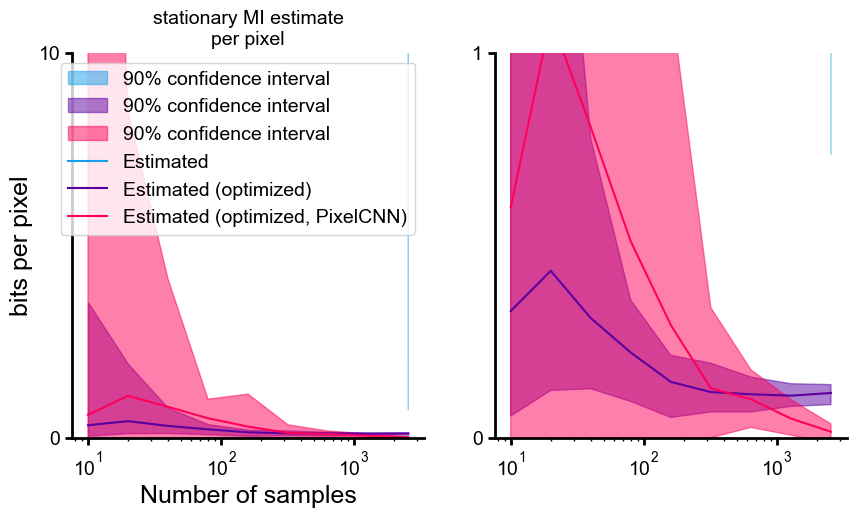

In [6]:
colors = get_color_cycle()

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
ax[0].fill_between(num_samples_to_use, stationary_mi_estimates_gp_conf_int[:,0], 
                stationary_mi_estimates_gp_conf_int[:,1], alpha=0.5, label=f'{confidence_interval}% confidence interval', color=colors[0])
ax[0].fill_between(num_samples_to_use, stationary_mi_estimates_gp_optimized_conf_int[:,0],
                stationary_mi_estimates_gp_optimized_conf_int[:,1], alpha=0.5, label=f'{confidence_interval}% confidence interval', color=colors[1])
ax[0].fill_between(num_samples_to_use, stationary_mi_estimates_pixelcnn_optimized_conf_int[:,0],
                stationary_mi_estimates_pixelcnn_optimized_conf_int[:,1], alpha=0.5, label=f'{confidence_interval}% confidence interval', color=colors[2])
ax[0].semilogx(num_samples_to_use, stationary_mi_estimates_gp_mean, label='Estimated', color=colors[0])
ax[0].semilogx(num_samples_to_use, stationary_mi_estimates_gp_optimized_mean, label='Estimated (optimized)', color=colors[1])
ax[0].semilogx(num_samples_to_use, stationary_mi_estimates_pixelcnn_optimized_mean, label='Estimated (optimized, PixelCNN)', color=colors[2])

ax[0].set(ylim=[0, 10], yticks=[0, 10])

ax[0].set(xlabel='Number of samples', title='stationary MI estimate\nper pixel', ylabel='bits per pixel')
clear_spines(ax[0])
ax[0].legend()


ax[1].fill_between(num_samples_to_use, stationary_mi_estimates_gp_conf_int[:,0], 
                stationary_mi_estimates_gp_conf_int[:,1], alpha=0.5, label=f'{confidence_interval}% confidence interval', color=colors[0])
ax[1].fill_between(num_samples_to_use, stationary_mi_estimates_gp_optimized_conf_int[:,0],
                stationary_mi_estimates_gp_optimized_conf_int[:,1], alpha=0.5, label=f'{confidence_interval}% confidence interval', color=colors[1])
ax[1].fill_between(num_samples_to_use, stationary_mi_estimates_pixelcnn_optimized_conf_int[:,0],
                stationary_mi_estimates_pixelcnn_optimized_conf_int[:,1], alpha=0.5, label=f'{confidence_interval}% confidence interval', color=colors[2])
ax[1].semilogx(num_samples_to_use, stationary_mi_estimates_gp_mean, label='Estimated', color=colors[0])
ax[1].semilogx(num_samples_to_use, stationary_mi_estimates_gp_optimized_mean, label='Estimated (optimized)', color=colors[1])
ax[1].semilogx(num_samples_to_use, stationary_mi_estimates_pixelcnn_optimized_mean, label='Estimated (optimized, PixelCNN)', color=colors[2])

ax[1].set(ylim=[0, 1], yticks=[0, 1])
clear_spines(ax[1])

fig.savefig('/home/hpinkard_waller/figures/mi_estimation/' + 'mi_estimator_consistency_real_samples' + '.pdf', transparent=True)